# Preparing realtime dataset

In [1]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_file_names(folder_path):
    import os, glob
    files = list()
    for filename in glob.glob(os.path.join(folder_path, '*.txt')):
        files.append(filename)         
    return files

def open_file(filename_with_path):
    """
    returns : Pd.DataFrame
    """
    import os
    import pandas as pd
    isfile = os.path.exists(filename_with_path)
    if not isfile:
        print("  {} does not exist. Exiting...".format(filename_with_path))
    else :
        with open(filename_with_path,"r") as f:
            next(f)
            content = f.readlines()
        content = [x.split("\t") for x in content]
        df = pd.DataFrame(content)     
        df.columns = ['Gx', 'Gy', 'Gz', 'Ax', 'Ay', 'Az', 'ClassLabel', 'StepLabel','None']
        
        # remove first row
        df =df.reindex(df.index.drop(0))
        
        # remove last column 'None'
        df = (df.iloc[:,:-1]).astype('float64')
        
        # removing -1 in stepLabel
        fdf = df.loc[(df['StepLabel']) >-1]
        
        # removing -1 in ClassLabel
        
        nfdf = fdf.loc[(fdf['ClassLabel']) >-1]
        
        return nfdf.reset_index(drop=True)
    




def filter_signal(raw_Signal, cutoff_frequency, nyq_freq, order):
    
    '''
    raw_Signal = DataFrame, shape(#of sample points,6)
    cutoff_frequency :
    nyq_freq: sampling_rate/2
    order:>0 
    returns : filtered_signal, shape((#of sample points,6))
    '''
    from scipy import signal
    def butter_lowpass(cutoff, nyq_freq, order):
    
        normal_cutoff = float(cutoff) / nyq_freq
        b, a = signal.butter(order, normal_cutoff, btype='lowpass')
        return b, a

    def butter_lowpass_filter(signal_, cutoff_freq, nyq_freq, order):
        '''
        data : 1D array    '''
        b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
        y = signal.filtfilt(b, a, signal_)
        return y
    
    filtered_Ax = butter_lowpass_filter(raw_Signal['Ax'], cutoff_frequency, nyq_freq, order)
    filtered_Ax = (pd.DataFrame(filtered_Ax, columns = ['Ax'], dtype = np.float64)).reset_index(drop = True)
    
    filtered_Ay = butter_lowpass_filter(raw_Signal['Ay'], cutoff_frequency, nyq_freq, order)
    filtered_Ay = (pd.DataFrame(filtered_Ay, columns = ['Ay'], dtype = np.float64)).reset_index(drop = True)

    filtered_Az = butter_lowpass_filter(raw_Signal['Az'], cutoff_frequency, nyq_freq, order)
    filtered_Az = (pd.DataFrame(filtered_Az, columns = ['Az'], dtype = np.float64)).reset_index(drop = True)

    filtered_Gx = butter_lowpass_filter(raw_Signal['Gx'], cutoff_frequency, nyq_freq, order)
    filtered_Gx = (pd.DataFrame(filtered_Gx, columns = ['Gx'], dtype = np.float64)).reset_index(drop = True)

    filtered_Gy = butter_lowpass_filter(raw_Signal['Gy'], cutoff_frequency, nyq_freq, order)
    filtered_Gy = (pd.DataFrame(filtered_Gy, columns = ['Gy'], dtype = np.float64)).reset_index(drop = True)
    
    filtered_Gz = butter_lowpass_filter(raw_Signal['Gz'], cutoff_frequency, nyq_freq, order)
    filtered_Gz = (pd.DataFrame(filtered_Gz, columns = ['Gz'], dtype = np.float64)).reset_index(drop = True)
    
    StepLabel = raw_Signal['StepLabel']
    StepLabel.columns = ['StepLabel']
    

    filtered_signal = pd.concat([filtered_Gx,filtered_Gy,filtered_Gz,filtered_Ax,filtered_Ay,filtered_Az,StepLabel],axis = 1) 
    
    return filtered_signal 
def signal_segmentation(signal, window_size, overlap = 0.99):
    '''
    signal : 1D numpy array or pandas Dataframe
    overlap : in percentage
    
    returns :numpy array
    '''
    
    if (window_size < 1):
        raise ValueError("Sliding window size may not be zero or negative")
        
    if (window_size > len(signal)):
        raise ValueError("Sliding window size may not exceed size of signal.")
    
    if not(0<=overlap<= 1):
        raise ValueError("Window overlap must be in within interval 0 and 1.")    
        
    sh = (signal.size - window_size + 1, window_size)
    st = signal.strides * 2    
    segmented_signal = np.lib.stride_tricks.as_strided(signal, strides = st, shape = sh)[0::int((overlap*window_size)+1)]
   
    return segmented_signal.transpose()

def segment_signal(raw_signal, window_size, overlap):
    
    '''
    raw_signal = DataFrame, shape(#of sample points,6)
    returns : filtered_signal, shape((#of sample points,6))
    '''
  
    segmented_Ax = signal_segmentation(raw_signal['Ax'], window_size, overlap)
    cols = ['Ax_segment_'+str(i+1) for i in range(len(segmented_Ax.transpose()))]
    segmented_Ax = (pd.DataFrame(segmented_Ax, columns = cols, dtype = np.float64)).reset_index(drop = True)

    segmented_Ay = signal_segmentation(raw_signal['Ay'], window_size, overlap)
    cols = ['Ay_segment_'+str(i+1) for i in range(len(segmented_Ay.transpose()))]
    segmented_Ay = (pd.DataFrame(segmented_Ay, columns = cols, dtype = np.float64)).reset_index(drop = True)

    segmented_Az = signal_segmentation(raw_signal['Az'],window_size, overlap)
    cols = ['Az_segment_'+str(i+1) for i in range(len(segmented_Az.transpose()))]
    segmented_Az = (pd.DataFrame(segmented_Az, columns = cols, dtype = np.float64)).reset_index(drop = True)

    segmented_Gx = signal_segmentation(raw_signal['Gx'],window_size, overlap)
    cols = ['Gx_segment_'+str(i+1) for i in range(len(segmented_Gx.transpose()))]
    segmented_Gx = (pd.DataFrame(segmented_Gx, columns = cols, dtype = np.float64)).reset_index(drop = True)

    segmented_Gy = signal_segmentation(raw_signal['Gy'], window_size, overlap)
    cols = ['Gy_segment_'+str(i+1) for i in range(len(segmented_Gy.transpose()))]
    segmented_Gy = (pd.DataFrame(segmented_Gy, columns = cols, dtype = np.float64)).reset_index(drop = True)
    
    segmented_Gz = signal_segmentation(raw_signal['Gz'], window_size, overlap)
    cols = ['Gz_segment_'+str(i+1) for i in range(len(segmented_Gz.transpose()))]
    segmented_Gz = (pd.DataFrame(segmented_Gz, columns = cols, dtype = np.float64)).reset_index(drop = True)

    segmented_signal = pd.concat([segmented_Gx,segmented_Gy,segmented_Gz,segmented_Ax,segmented_Ay,segmented_Az],axis = 1) 
     
    return segmented_signal
def feature_vector(segmented_signal):  
    '''
    segmented_signal : pandas DataFrame, shape(#of samples in a segment,#of segment*6)
    returns: feature_vector, DataFrame, shape(#of segments, #of features calculated)
    
    '''
    
    import pandas as pd
       
    r,c = segmented_signal.shape    
    feature_matrix_t = pd.DataFrame()
    feature_matrix_f = pd.DataFrame()
    for i in range(int(c/6)):
        Ax = pd.DataFrame(segmented_signal['Ax_segment_'+str(i+1)])
        Ay = pd.DataFrame(segmented_signal['Ay_segment_'+str(i+1)])
        Az = pd.DataFrame(segmented_signal['Az_segment_'+str(i+1)])
        Gx = pd.DataFrame(segmented_signal['Gx_segment_'+str(i+1)])
        Gy = pd.DataFrame(segmented_signal['Gy_segment_'+str(i+1)])
        Gz = pd.DataFrame(segmented_signal['Gz_segment_'+str(i+1)])
        segment = pd.concat([Gx,Gy,Gz,Ax,Ay,Az],axis = 1)
        feature_t = time_domain_features(segment)
        feature_f = frequency_domain_features(segment)
        feature_matrix_t = (pd.concat([feature_matrix_t,feature_t],axis = 0)).reset_index(drop = True) 
        feature_matrix_f = (pd.concat([feature_matrix_f,feature_f],axis = 0)).reset_index(drop = True)
        x = (pd.concat([feature_matrix_t,feature_matrix_f],axis = 1)).reset_index(drop = True)
                  
    return x 
def time_domain_features(segmented_signal):
    '''segmented_signal: numpy array, shape(#of samples in window ,6) e.g 128*6
        returns = shape(1, #of features calculated)
        
    '''
    import numpy as np
    import pandas as pd
    
    
    
    def energy_(x):
        return (np.square(x)).sum()
    
    #--------------------------------------------------------------------
    # https://dsp.stackexchange.com/questions/18649/signal-magnitude-area
    # https://en.wikipedia.org/wiki/Signal_magnitude_area
    def signal_magnitude_area(x, y, z):
        import numpy as np        
        sum_ = 0
        if not(len(x)==len(y)) or not(len(x)==len(z)):
            raise ValueError(" Length of x,y,z must be same.")
                
        for i in range (len(x)):
            sum_ += (np.abs(x[i]) + np.abs(y[i]) + np.abs(z[i]))
        return sum_ /len(x)
    
    #-----------------------------------------------------------------------
    # https://en.wikipedia.org/wiki/Root_mean_square
    def RMS(x):
        '''1D np.array '''    
          
        return np.sqrt(np.mean(np.square(x)))
    
    # -----------------------------------------------------------------------
    def crest_factor(x):
        '''x: 1d np.array
        # https://www.kdnuggets.com/2018/04/descriptive-statistics-mighty-dwarf-data-science-crest-factor.html
        '''
        return np.max(np.abs(x))/RMS(x)
    
    # https://informatique-python.readthedocs.io/fr/latest/Exercices/mad.html 
    def median_abs_deviation(x, axis=None):
        """
        Compute *Median Absolute Deviation* of an array along given axis.
        """
    
        # Median along given axis, but *keeping* the reduced axis so that
        # result can still broadcast against a.
        med = np.median(x, axis=axis, keepdims=True)
        mad = np.median(np.absolute(x - med), axis=axis) # MAD along given axis
    
        return mad
    
    
    def mean_crossing_rate(x):
        
        return ((x[:-1] * x[1:]) < np.mean(x)).sum()
    
    
    
    def zero_crossing_rate(x):
        '''x : 1d Numpy array'''
        return ((x[:-1] * x[1:]) < 0).sum()

          
    segmented_signal = pd.DataFrame(segmented_signal,dtype = np.float64)     
    segmented_signal.columns = ['Gx', 'Gy', 'Gz', 'Ax', 'Ay', 'Az']
    
    # mean 
    mean = (pd.DataFrame(segmented_signal.mean(axis = 0))).transpose()
    mean.columns =['t_mean_Gx','t_mean_Gy','t_mean_Gz','t_mean_Ax','t_mean_Ay','t_mean_Az']
    mean = mean.reset_index(drop = True)
    
    # standard deviation
    std = (pd.DataFrame(segmented_signal.std(axis = 0))).transpose()
    std.columns =['t_std_Gx','t_std_Gy','t_std_Gz','t_std_Ax','t_std_Ay','t_std_Az']
    std = std.reset_index(drop = True)
    
    # variance
    variance = (pd.DataFrame(segmented_signal.median(axis = 0))).transpose()
    variance.columns =['t_variance_Gx','t_variance_Gy','t_variance_Gz','t_variance_Ax','t_variance_Ay','t_variance_Az']
    variance = variance.reset_index(drop = True)
    
    # max
    max_ = (pd.DataFrame(segmented_signal.max(axis = 0))).transpose()
    max_.columns =['t_max_Gx','t_max_Gy','t_max_Gz','t_max_Ax','t_max_Ay','t_max_Az']
    max_ = max_.reset_index(drop = True)
    
    # min
    min_ = (pd.DataFrame(segmented_signal.min(axis = 0))).transpose()
    min_.columns =['t_min_Gx','t_min_Gy','t_min_Gz','t_min_Ax','t_min_Ay','t_min_Az']
    min_ = min_.reset_index(drop = True)
    
    # mean absolute deviation (MAD)
    MAD = (pd.DataFrame(segmented_signal.mad(axis = 0))).transpose()
    MAD.columns =['t_MAD_Gx','t_MAD_Gy','t_MAD_Gz','t_MAD_Ax','t_MAD_Ay','t_ MAD_Az']
    MAD = MAD.reset_index(drop = True)
    
    # skewness
    skewness = (pd.DataFrame(segmented_signal.skew(axis = 0))).transpose()
    skewness.columns =['t_skewness_Gx','t_skewness_Gy','t_skewness_Gz','t_skewness_Ax','t_skewness_Ay','t_skewness_Az']
    skewness = skewness.reset_index(drop = True)
    
    # kurtosis
    kurtosis = (pd.DataFrame(segmented_signal.kurtosis(axis = 0))).transpose()
    kurtosis.columns =['t_kurtosis_Gx','t_kurtosis_Gy','t_kurtosis_Gz','t_kurtosis_Ax','t_kurtosis_Ay','t_kurtosis_Az']
    kurtosis = kurtosis.reset_index(drop = True)
    
    # Q1
    Q1 = (segmented_signal.quantile([0.25]))
    Q1.columns =['t_Q1_Gx','t_Q1_Gy','t_Q1_Gz','t_Q1_Ax','t_Q1_Ay','t_Q1_Az']
    Q1 = Q1.reset_index(drop = True)
    
    
    # median (Q2)
    median = (pd.DataFrame(segmented_signal.median(axis = 0))).transpose()
    median.columns =['t_median_Gx','t_median_Gy','t_median_Gz','t_median_Ax','t_median_Ay','t_median_Az']
    median = median.reset_index(drop = True)
    
    # Q3
    Q3 = (segmented_signal.quantile([0.75]))
    Q3.columns =['t_Q3_Gx','t_Q3_Gy','t_Q3_Gz','t_Q3_Ax','t_Q3_Ay','t_Q3_Az']
    Q3 = Q3.reset_index(drop = True)
    
    # Inter Quartile Range
    Q3.columns = ['Gx', 'Gy', 'Gz', 'Ax', 'Ay', 'Az']
    Q1.columns = ['Gx', 'Gy', 'Gz', 'Ax', 'Ay', 'Az']
    InterQR = Q3.sub(Q1)    
    InterQR.columns =['t_IQR_Gx','t_IQR_Gy','t_IQR_Gz','t_IQR_Ax','t_IQR_Ay','t_IQR_Az']
    InterQR = InterQR.reset_index(drop = True)
    Q1.columns =['t_Q1_Gx','t_Q1_Gy','t_Q1_Gz','t_Q1_Ax','t_Q1_Ay','t_Q1_Az']
    Q3.columns =['t_Q3_Gx','t_Q3_Gy','t_Q3_Gz','t_Q3_Ax','t_Q3_Ay','t_Q3_Az']
    
    # RMS value     
    rms = pd.DataFrame(segmented_signal.apply(RMS,axis = 0)).transpose()
    rms.columns = ['t_RMS_Gx','t_RMS_Gy','t_RMS_Gz','t_RMS_Ax','t_RMS_Ay','t_RMS_Az']
    rms = rms.reset_index(drop = True)
    
    
    # energy     
    eng = pd.DataFrame(segmented_signal.apply(energy_,axis = 0)).transpose()
    eng.columns = ['t_energy_Gx','t_energy_Gy','t_energy_Gz','t_energy_Ax','t_energy_Ay','t_energy_Az']
    eng = eng.reset_index(drop = True)
    
        
    # crest factor
    Crest_factor =pd.DataFrame(segmented_signal.apply(crest_factor,axis = 0)).transpose() 
    Crest_factor.columns = ['t_Crest_factor_Gx','t_Crest_factor_Gy','t_Crest_factor_Gz','t_Crest_factor_Ax','t_Crest_factor','t_Crest_factor_Az']
    Crest_factor = Crest_factor.reset_index(drop = True)
    
    # median absolute deviation (mad)
    mad = pd.DataFrame(segmented_signal.apply(median_abs_deviation,axis = 0)).transpose() 
    mad.columns =['t_mad_Gx','t_mad_Gy','t_mad_Gz','t_mad_Ax','t_mad_Ay','t_mad_Az']
    mad = mad.reset_index(drop = True)
    
    # zero crossing rate(ZCR)
    zcr = pd.DataFrame(segmented_signal.apply(zero_crossing_rate,axis = 0)).transpose() 
    zcr.columns =['t_zcr_Gx','t_zcr_Gy','t_zcr_Gz','t_zcr_Ax','t_zcr_Ay','t_zcr_Az']
    zcr = zcr.reset_index(drop = True)
            
    # Signal Magnitude Area    
    #----------------------------------------------------------------------------------------------
    Ax,Ay,Az =segmented_signal['Ax'].values,segmented_signal['Ay'].values,segmented_signal['Az'].values
    Gx,Gy,Gz =segmented_signal['Gx'].values,segmented_signal['Gy'].values,segmented_signal['Gz'].values
    sma_Acc = signal_magnitude_area(Ax, Ay,Az)
    sma_Gyro = signal_magnitude_area(Gx, Gy,Gz)
    sma = (pd.DataFrame(np.array([sma_Acc,sma_Gyro]),dtype = np.float64)).transpose()
    sma.columns = ['t_sma_Acc','t_sma_Gyro']
    sma = sma.reset_index(drop = True)
    
       
    # simple moving averages(SMA)
    
    #----------------------------------------------------------------------------------------------
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4719690/   
    
    feature_vector = pd.concat([mean,std,variance,max_,min_,MAD,skewness,
                                kurtosis,Q1,median,Q3,InterQR,rms,eng,Crest_factor,mad,
                                zcr,sma],axis = 1)  
    return feature_vector

def frequency_domain_features(segmented_signal):
    '''segmented_signal: numpy array, shape(#of samples in window ,6) e.g 128*6
        returns = shape(1, #of features calculated)
        
    '''
    import numpy as np
    import pandas as pd
    import scipy
    
    #--------------------------------------------------------------------
    # https://dsp.stackexchange.com/questions/18649/signal-magnitude-area
    # https://en.wikipedia.org/wiki/Signal_magnitude_area
    def signal_magnitude_area(x, y, z):
        import numpy as np        
        sum_ = 0
        if not(len(x)==len(y)) or not(len(x)==len(z)):
            raise ValueError(" Length of x,y,z must be same.")
                
        for i in range (len(x)):
            sum_ += (np.abs(x[i]) + np.abs(y[i]) + np.abs(z[i]))
        return sum_ /len(x)
    
    #-----------------------------------------------------------------------
    # https://en.wikipedia.org/wiki/Root_mean_square
    def RMS(x):
        '''1D np.array '''    
          
        return np.sqrt(np.mean(np.square(x)))
    
    # -----------------------------------------------------------------------
    def crest_factor(x):
        '''x: 1d np.array
        # https://www.kdnuggets.com/2018/04/descriptive-statistics-mighty-dwarf-data-science-crest-factor.html
        '''
        return np.max(np.abs(x))/RMS(x)
    
    # https://informatique-python.readthedocs.io/fr/latest/Exercices/mad.html 
    def median_abs_deviation(x, axis=None):
        """
        Compute *Median Absolute Deviation* of an array along given axis.
        """
    
        # Median along given axis, but *keeping* the reduced axis so that
        # result can still broadcast against a.
        med = np.median(x, axis=axis, keepdims=True)
        mad = np.median(np.absolute(x - med), axis=axis) # MAD along given axis
    
        return mad
    
    
    def mean_crossing_rate(x):
        
        return ((x[:-1] * x[1:]) < np.mean(x)).sum()
    
    
    
    def zero_crossing_rate(x):
        '''x : 1d Numpy array'''
        return ((x[:-1] * x[1:]) < 0).sum()

    
    segmented_signal = pd.DataFrame(segmented_signal,dtype = np.float64)     
    segmented_signal.columns = ['Gx', 'Gy', 'Gz', 'Ax', 'Ay', 'Az']
    
    
    # first converting the signal to frequency domain
    segmented_signal = segmented_signal.apply(scipy.fftpack.rfft,axis =0)
    
    
    # meanFreq,bandsenergy,medianfreq,SNR,power spectrum deformation,peak frequency,variance opf central freq
    # mean power, freq ratio,slope sign change
    
    # mean 
    mean = (pd.DataFrame(segmented_signal.mean(axis = 0))).transpose()
    mean.columns =['f_mean_Gx','f_mean_Gy','f_mean_Gz','f_mean_Ax','f_mean_Ay','f_mean_Az']
    mean = mean.reset_index(drop = True)
    
    # standard deviation
    std = (pd.DataFrame(segmented_signal.std(axis = 0))).transpose()
    std.columns =['f_std_Gx','f_std_Gy','f_std_Gz','f_std_Ax','f_std_Ay','f_std_Az']
    std = std.reset_index(drop = True)
    
    # variance
    variance = (pd.DataFrame(segmented_signal.median(axis = 0))).transpose()
    variance.columns =['f_variance_Gx','f_variance_Gy','f_variance_Gz','f_variance_Ax','f_variance_Ay','f_variance_Az']
    variance = variance.reset_index(drop = True)
    
    # max
    max_ = (pd.DataFrame(segmented_signal.max(axis = 0))).transpose()
    max_.columns =['f_max_Gx','f_max_Gy','f_max_Gz','f_max_Ax','f_max_Ay','f_max_Az']
    max_ = max_.reset_index(drop = True)
    
    # min
    min_ = (pd.DataFrame(segmented_signal.min(axis = 0))).transpose()
    min_.columns =['f_min_Gx','f_min_Gy','f_min_Gz','f_min_Ax','f_min_Ay','f_min_Az']
    min_ = min_.reset_index(drop = True)
    
    # mean absolute deviation (MAD)
    MAD = (pd.DataFrame(segmented_signal.mad(axis = 0))).transpose()
    MAD.columns =['f_MAD_Gx','f_MAD_Gy','f_MAD_Gz','f_MAD_Ax','f_MAD_Ay','f_ MAD_Az']
    MAD = MAD.reset_index(drop = True)
    
    # skewness
    skewness = (pd.DataFrame(segmented_signal.skew(axis = 0))).transpose()
    skewness.columns =['f_skewness_Gx','f_skewness_Gy','f_skewness_Gz','f_skewness_Ax','f_skewness_Ay','f_skewness_Az']
    skewness = skewness.reset_index(drop = True)
    
    # kurtosis
    kurtosis = (pd.DataFrame(segmented_signal.kurtosis(axis = 0))).transpose()
    kurtosis.columns =['f_kurtosis_Gx','f_kurtosis_Gy','f_kurtosis_Gz','f_kurtosis_Ax','f_kurtosis_Ay','f_kurtosis_Az']
    kurtosis = kurtosis.reset_index(drop = True)
    
    # Q1
    Q1 = (segmented_signal.quantile([0.25]))
    Q1.columns =['f_Q1_Gx','f_Q1_Gy','f_Q1_Gz','f_Q1_Ax','f_Q1_Ay','f_Q1_Az']
    Q1 = Q1.reset_index(drop = True)
    
    
    # median (Q2)
    median = (pd.DataFrame(segmented_signal.median(axis = 0))).transpose()
    median.columns =['f_median_Gx','f_median_Gy','f_median_Gz','f_median_Ax','f_median_Ay','f_median_Az']
    median = median.reset_index(drop = True)
    
    # Q3
    Q3 = (segmented_signal.quantile([0.75]))
    Q3.columns =['f_Q3_Gx','f_Q3_Gy','f_Q3_Gz','f_Q3_Ax','f_Q3_Ay','f_Q3_Az']
    Q3 = Q3.reset_index(drop = True)
    
    # Inter Quartile Range
    Q3.columns = ['Gx', 'Gy', 'Gz', 'Ax', 'Ay', 'Az']
    Q1.columns = ['Gx', 'Gy', 'Gz', 'Ax', 'Ay', 'Az']
    InterQR = Q3.sub(Q1)    
    InterQR.columns =['f_IQR_Gx','f_IQR_Gy','f_IQR_Gz','f_IQR_Ax','f_IQR_Ay','f_IQR_Az']
    InterQR = InterQR.reset_index(drop = True)
    Q1.columns =['f_Q1_Gx','f_Q1_Gy','f_Q1_Gz','f_Q1_Ax','f_Q1_Ay','f_Q1_Az']
    Q3.columns =['f_Q3_Gx','f_Q3_Gy','f_Q3_Gz','f_Q3_Ax','f_Q3_Ay','f_Q3_Az']
    
    # RMS value     
    rms = pd.DataFrame(segmented_signal.apply(RMS,axis = 0)).transpose()
    rms.columns = ['f_RMS_Gx','f_RMS_Gy','f_RMS_Gz','f_RMS_Ax','f_RMS','f_RMS_Az']
    rms = rms.reset_index(drop = True)
    
    # crest factor
    Crest_factor =pd.DataFrame(segmented_signal.apply(crest_factor,axis = 0)).transpose() 
    Crest_factor.columns = ['f_Crest_factor_Gx','f_Crest_factor_Gy','f_Crest_factor_Gz','f_Crest_factor_Ax','f_Crest_factor','f_Crest_factor_Az']
    Crest_factor = Crest_factor.reset_index(drop = True)
    
    # median absolute deviation (mad)
    mad = pd.DataFrame(segmented_signal.apply(median_abs_deviation,axis = 0)).transpose() 
    mad.columns =['f_mad_Gx','f_mad_Gy','f_mad_Gz','f_mad_Ax','f_mad_Ay','f_mad_Az']
    mad = mad.reset_index(drop = True)
    
    # zero crossing rate(ZCR)
    zcr = pd.DataFrame(segmented_signal.apply(zero_crossing_rate,axis = 0)).transpose() 
    zcr.columns =['f_zcr_Gx','f_zcr_Gy','f_zcr_Gz','f_zcr_Ax','f_zcr_Ay','f_zcr_Az']
    zcr = zcr.reset_index(drop = True)
    
       
    
    # Signal Magnitude Area    
    #----------------------------------------------------------------------------------------------
    Ax,Ay,Az =segmented_signal['Ax'].values,segmented_signal['Ay'].values,segmented_signal['Az'].values
    Gx,Gy,Gz =segmented_signal['Gx'].values,segmented_signal['Gy'].values,segmented_signal['Gz'].values
    sma_Acc = signal_magnitude_area(Ax, Ay,Az)
    sma_Gyro = signal_magnitude_area(Gx, Gy,Gz)
    sma = (pd.DataFrame(np.array([sma_Acc,sma_Gyro]),dtype = np.float64)).transpose()
    sma.columns = ['f_sma_Acc','f_sma_Gyro']
    sma = sma.reset_index(drop = True)
    
       
    # simple moving averages(SMA)
    
    #----------------------------------------------------------------------------------------------
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4719690/   
    
    feature_vector = pd.concat([mean,std,variance,max_,min_,MAD,skewness,
                                kurtosis,Q1,median,Q3,InterQR,rms,Crest_factor,mad,
                                zcr,sma],axis = 1)      
    
    return feature_vector

def create_X(files,cutoff_frequency,nyq_freq, order,window_size,overlap):
    import pandas as pd
    from tqdm import tqdm
    No_of_files = len(files)
    X_pos = pd.DataFrame()
    X_neg = pd.DataFrame()
    for i in tqdm(range(No_of_files)):
        #print('Opening {}th files...'.format(i+1))
        raw_signal_all =open_file(files[i])
        
        #print(files[i])
        raw_signal = raw_signal_all.iloc[:,0:8]        
        
        #print('Filtering {}th files...'.format(i+1))
        if (order > 0):        
            filtered_signal = filter_signal(raw_signal,cutoff_frequency, nyq_freq, order)
            
        else:# no filtering case
            filtered_signal = raw_signal
            
        
        #print('Segmenting {}th files...'.format(i+1))
        segmented_signal = segment_signal(filtered_signal, window_size, overlap)
        #print(segmented_signal[1])
       
        #print('Extracting features from {}th files...'.format(i))
        x_ = feature_vector(segmented_signal)
        
        X_pos = (pd.concat([x_,X_pos],axis = 0)).reset_index(drop = True)
        #print("*****************************************************")

    return X_pos
import pandas as pd
import numpy as np
from tqdm import tqdm

files_center = load_file_names(r'C:\Users\narayan\Desktop\FinalCode_thesis\EvaluationData\Center')
files_left = load_file_names(r'C:\Users\narayan\Desktop\FinalCode_thesis\EvaluationData\Left')
files_right = load_file_names(r'C:\Users\narayan\Desktop\FinalCode_thesis\EvaluationData\Right')

cutoff_frequency = 15.0
sample_rate = 100
nyq_freq = sample_rate/2
order = 4
window_size = 27
overlap = 0.99
c202test = create_X(files_center,cutoff_frequency,nyq_freq,order,window_size,overlap)
r202test  =create_X(files_right,cutoff_frequency,nyq_freq,order,window_size,overlap)
l202test = create_X(files_left,cutoff_frequency,nyq_freq,order,window_size,overlap)


# real time test datasets
CLR202Test = (pd.concat([c202test,l202test,r202test],axis = 0)).reset_index(drop = True)

C202Test = c202test.copy()

L202Test = l202test.copy()

R202Test =  r202test.copy()

CL202Test = (pd.concat([c202test,l202test],axis = 0)).reset_index(drop = True)

CR202Test = (pd.concat([c202test, r202test],axis = 0)).reset_index(drop = True)

LR202Test = (pd.concat([l202test, r202test],axis = 0)).reset_index(drop = True)

#606 CLR features style
import numpy as np

feature_names_C = C202Test.columns.tolist()
feature_names_L = L202Test.columns.tolist()
feature_names_R = R202Test.columns.tolist()

for i in range(len(feature_names_C)):
    feature_names_C[i] = 'C_'+ str(feature_names_C[i])

    
for i in range(len(feature_names_L)):
    feature_names_L[i] = 'L_'+ str(feature_names_L[i])
    
for i in range(len(feature_names_R)):
    feature_names_R[i] = 'R_'+ str(feature_names_R[i])

C202Test.columns = feature_names_C
L202Test.columns = feature_names_L
R202Test.columns = feature_names_R



CLR606Test = (pd.concat([C202Test,L202Test, R202Test.iloc[0:53,:]],axis = 1)).reset_index(drop = True)
CL404Test = (pd.concat([C202Test,L202Test],axis = 1)).reset_index(drop = True)
CR404Test = (pd.concat([C202Test, R202Test.iloc[0:53,:]],axis = 1)).reset_index(drop = True)
LR404Test = (pd.concat([L202Test, R202Test.iloc[0:53,:]],axis = 1)).reset_index(drop = True)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.06s/it]


In [2]:
import warnings
warnings.filterwarnings("ignore")
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,f1_score,roc_curve, auc,roc_auc_score,precision_score,recall_score,matthews_corrcoef


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif,f_classif
np.set_printoptions(precision=3)


def feature_ranking_selection(X_train, y_train, n_features):
    '''
    n_features: number of feature to select for training
    
    returns: feature name with pearson correlation coefficient(in descending) and selected n_features
    
    '''
    
    df = X_train.copy()
    df['label'] = y_train.values
    
    correlation_mat = df.corr(method = 'pearson')    
    feature_name = list(correlation_mat.index)   
    
    ndf = pd.DataFrame()
    ndf['feature'] = feature_name
    ndf ['importance'] = abs((correlation_mat.iloc[:,-1]).values )
    
    mdf = ndf[:-1]    
    mdf = (mdf.sort_values(by='importance', ascending=False)).reset_index(drop = True)
    
    if n_features > len(mdf):
        print('Number features to select is too large.')
        return mdf
    else: 
        selected_feature = list((mdf.iloc[0:n_features])['feature'].values)
        return mdf, selected_feature

# CLR202

				Classifier: DECISION TREE
---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
		Before Feature Selection	After Feature Selection
No. of features:	 202 			 15
Train Accuracy:		 100.0 			 99.14
Step Detected:		 9 			 31
27 is actual number of step in ID008440 


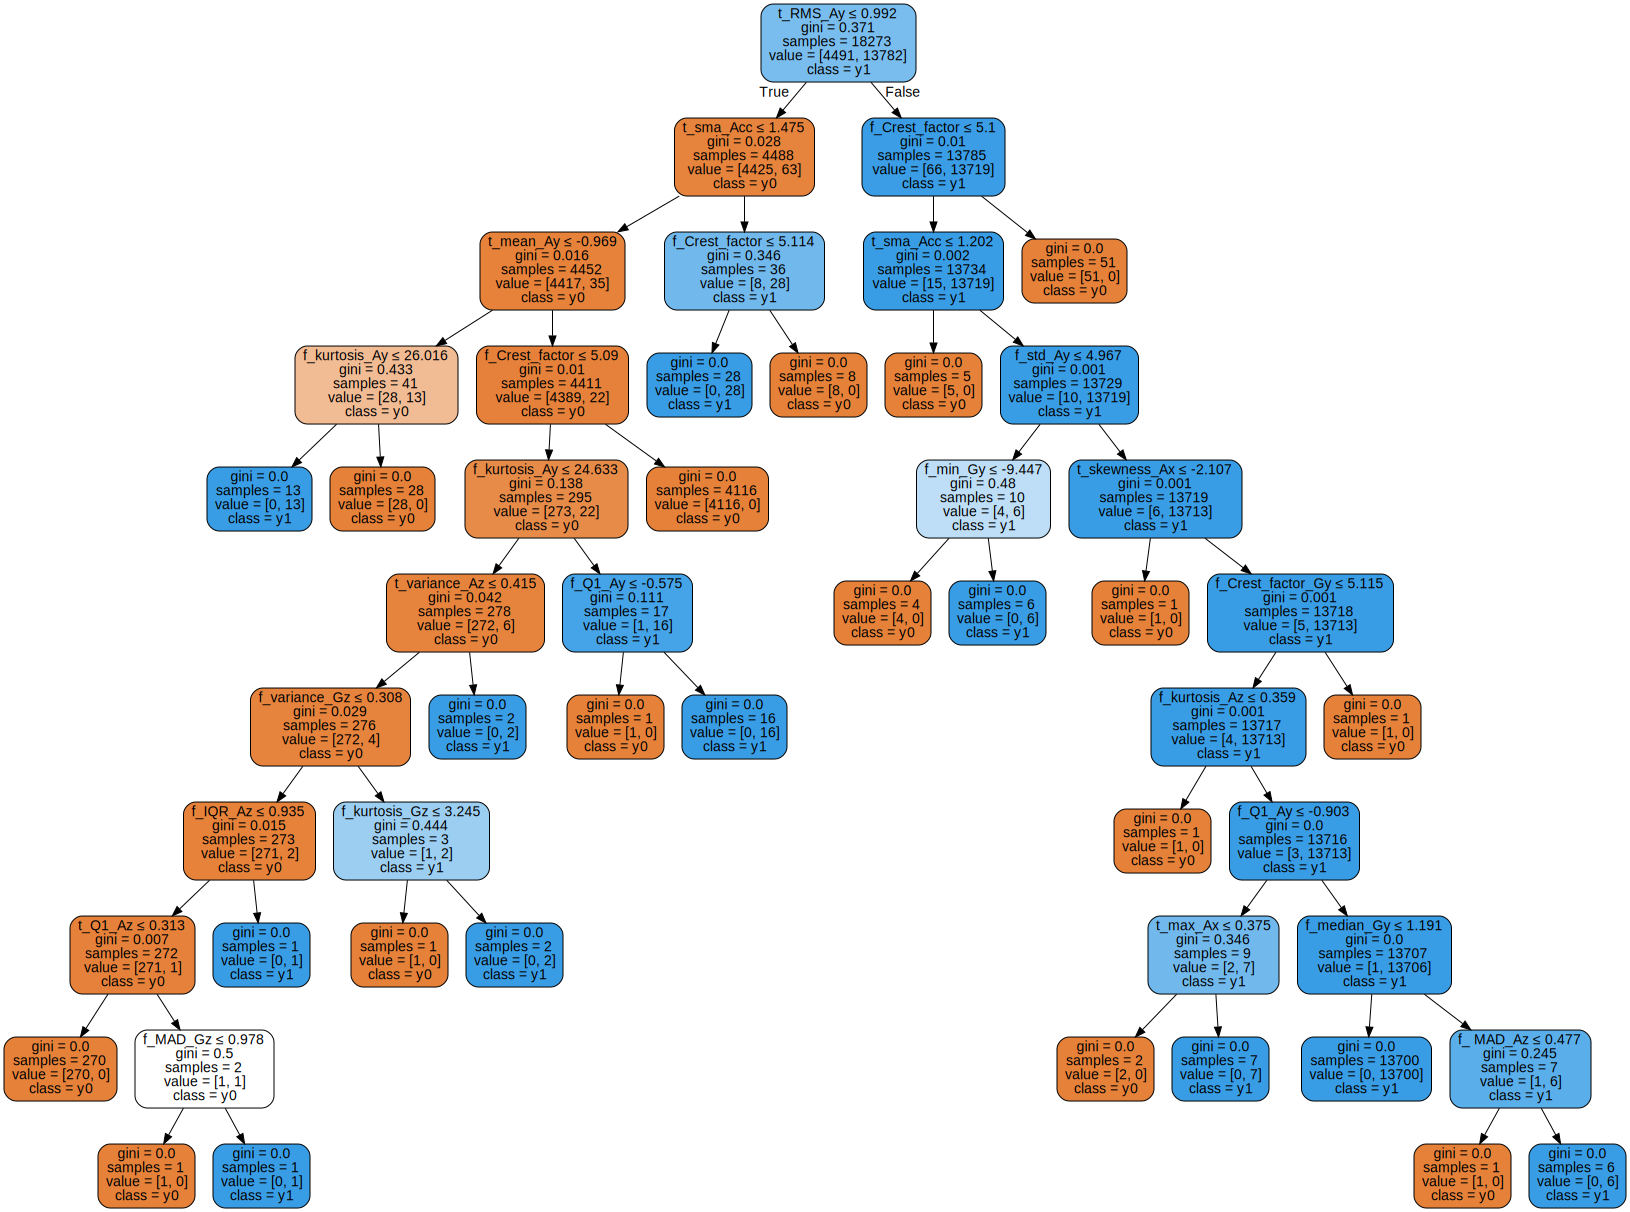

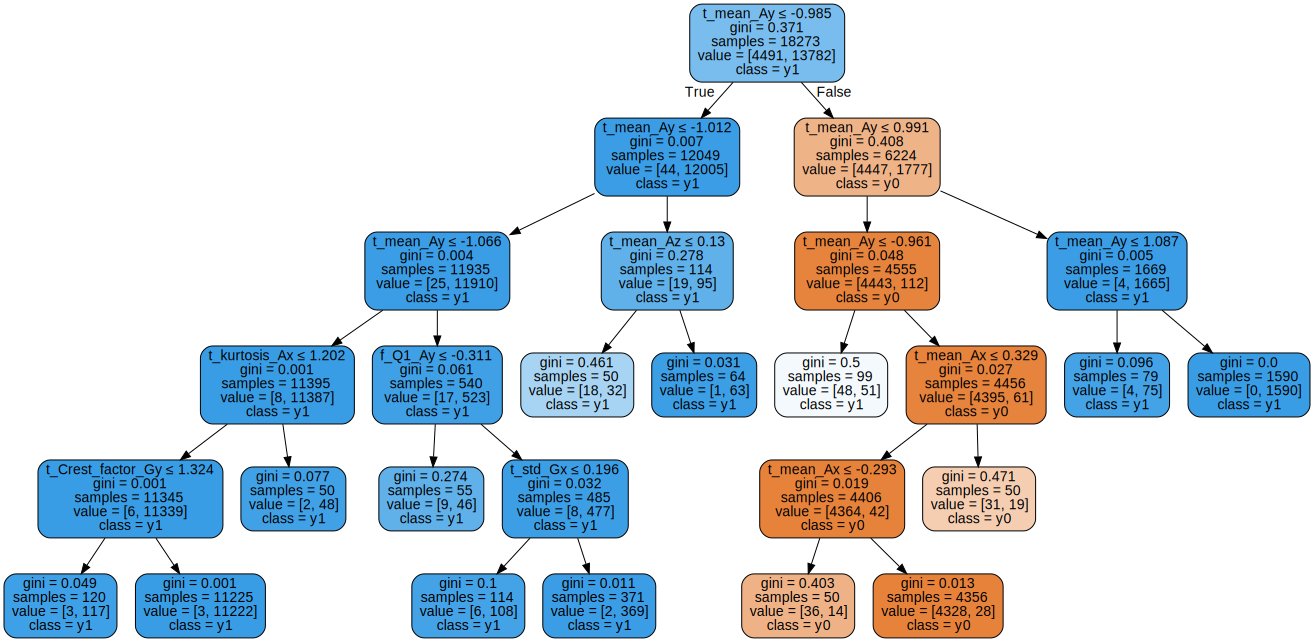

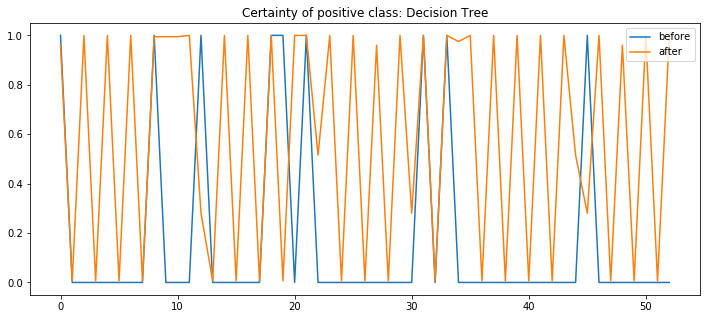

In [3]:
#Load dataset as pandas data frame
filename = "CLR_both_202.csv"
dataset = pd.read_csv(filename)

#Split data into input and output variable
X = dataset.iloc[:,0:dataset.shape[1]-1]
Y = dataset.iloc[:,-1]

X_trainB, X_testB, y_trainB, y_testB = train_test_split(X, Y,test_size=0.7,random_state = 100)
X_trainA, X_testA, y_trainA, y_testA = train_test_split(X, Y,test_size=0.7,random_state = 100)

# Removing Constant features
constant_filter = VarianceThreshold()
constant_filter.fit(X_trainA)
constant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[constant_filter.get_support()]]
X_trainA.drop(labels=constant_columns,axis=1, inplace=True) 
X_testA.drop(labels=constant_columns,axis=1, inplace=True)


RtestB = l202test.copy()
RtestA = l202test.copy()

RtestA.drop(labels=constant_columns,axis=1, inplace=True)

# Removing Quasi-Constant features
qconstant_filter = VarianceThreshold(0.01)
qconstant_filter.fit(X_trainA)
qconstant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[qconstant_filter.get_support()]]
X_trainA.drop(labels=qconstant_columns,axis=1, inplace=True) 
X_testA.drop(labels=qconstant_columns,axis=1, inplace=True)
RtestA.drop(labels=qconstant_columns,axis=1, inplace=True)

# Removing Correlated Features
correlated_features = set()  
correlation_matrix = X_trainA.corr(method = 'pearson')
for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.4:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
X_trainA.drop(labels=correlated_features,axis=1, inplace=True) 
X_testA.drop(labels=correlated_features,axis=1, inplace=True)
RtestA.drop(labels=correlated_features,axis=1, inplace=True)

# feature ranking and selection    
ranking_info, selected_features = feature_ranking_selection(X_trainA, y_trainA, 15)
X_trainA = X_trainA[selected_features]        
X_testA = X_testA[selected_features] 
RtestA = RtestA[selected_features]

#names = ["Nearest Neighbors","Decision Tree","Naive Bayes"]
names = ["Decision Tree"]

classifiers = [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(random_state = 100)
    #GaussianNB(),
   ]
classifier2= [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier( max_depth = 5, min_samples_leaf = 50,random_state = 100)
    #GaussianNB(),
   ]
clf_bef = list()
clf_aft = list()

for name, clf, dlf in zip(names,classifiers,classifier2):
      
    
    # Before Feature Selection
    startB = time.time()
    clf.fit(X_trainB,y_trainB)
    #plot_decision_boundary(clf, X = X_train,Y = y_train)
    endB = time.time() 
    clf_bef.append(clf)
   # plot_decision_boundary(clf, X = X_train,Y = y_train)
    
    # after Feature Selection    
    startA = time.time()
    dlf.fit(X_trainA,y_trainA)
    endA = time.time()
    clf_aft.append(dlf)
    #plot_decision_boundary(dlf, X = X_train,Y = y_train)
    
    print('\t\t\t\tClassifier:',name.upper())
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')
         
    print('\t\tBefore Feature Selection\tAfter Feature Selection')
    print('No. of features:\t', X_trainB.shape[1],'\t\t\t',X_trainA.shape[1])
    train_predB = clf.predict(X_trainB)
    train_predA = dlf.predict(X_trainA)
    train_accB = round(accuracy_score(y_trainB,train_predB)*100, 2)
    train_accA = round(accuracy_score(y_trainA,train_predA)*100, 2)
    print('Train Accuracy:\t\t',train_accB,'\t\t\t',train_accA)
   
    class1B = clf.predict_proba(RtestB)[:,1]
    class1A = dlf.predict_proba(RtestA)[:,1]
    stepB = len(class1B[class1B >0.5])
    stepA = len(class1A[class1A >0.5])
    print('Step Detected:\t\t',stepB,'\t\t\t',stepA)
    print('27 is actual number of step in ID008440 ')

    
from sklearn.externals.six import StringIO
import pydotplus
from sklearn.tree import export_graphviz
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# plotting class probabilities
for name, clf, dlf in zip(names, clf_bef, clf_aft):
    # before feature selection
    
    columnsB=list(X_testB.columns)
    dot_data = StringIO()
    export_graphviz(clf,out_file=dot_data,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    graph.write_pdf(filename[:-4] +"_Before.pdf")
    # to display
    display(graphviz.Source(export_graphviz(clf,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)))
    
    # after feature selection
    columnsA=list(X_testA.columns)
    dot_dataA = StringIO()
    export_graphviz(dlf,out_file=dot_dataA,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_dataA.getvalue()) 
    graph.write_pdf(filename[:-4] +"_After.pdf")
    display(graphviz.Source(export_graphviz(dlf,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)))  
         
    class1B = clf.predict_proba(RtestB)[:,1]
    #print(class1B)
    class1A = dlf.predict_proba(RtestA)[:,1]
    #print(class1A)
    plt.figure(figsize=(12,5))
    plt.title('Certainty of positive class: ')
    plt.plot(class1B,label = 'before feature selecton', color = 'red')
    plt.plot(class1A,label = 'after feature selection')
    plt.legend(loc='upper right',ncol=1)
    plt.savefig('StepProbability.pdf', dpi = 1500)
    plt.show()

# C202

				Classifier: DECISION TREE
---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
		Before Feature Selection	After Feature Selection
No. of features:	 202 			 15
Step Detected:		 11 			 29
27 is actual number of step in ID008440 


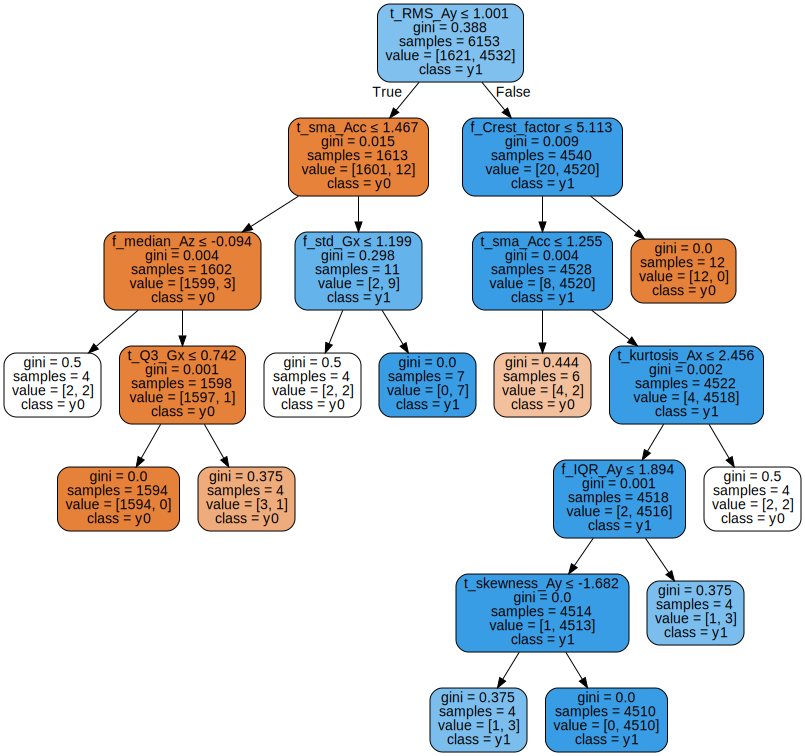

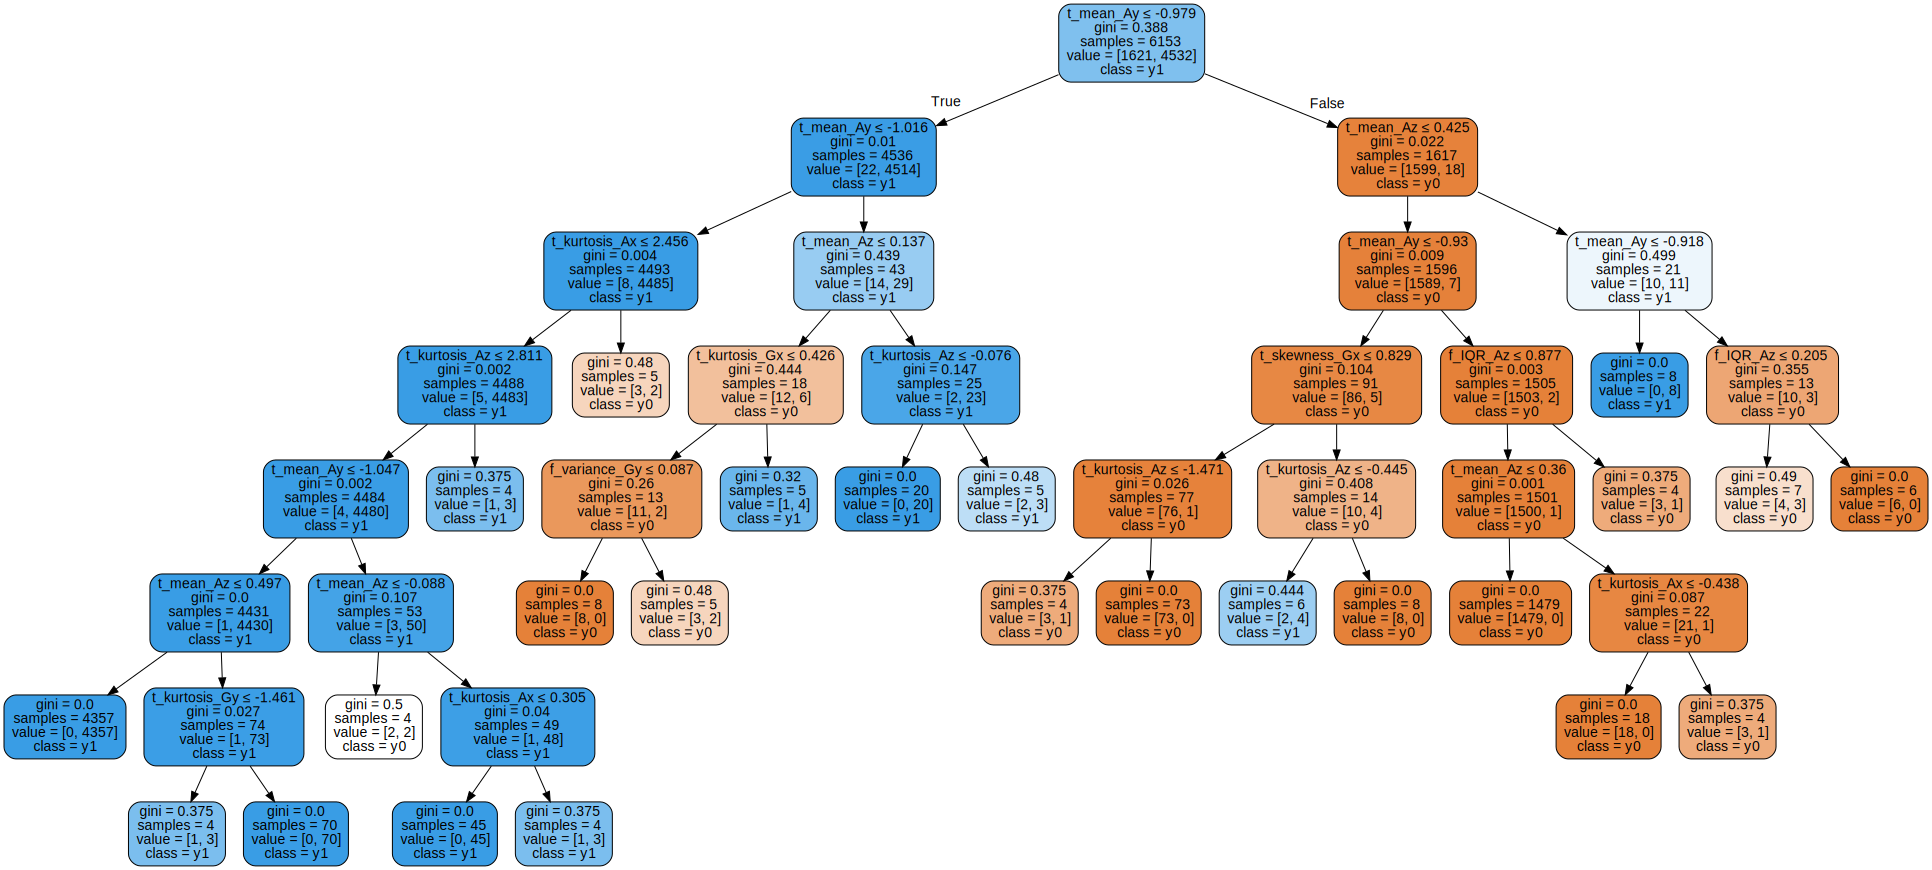

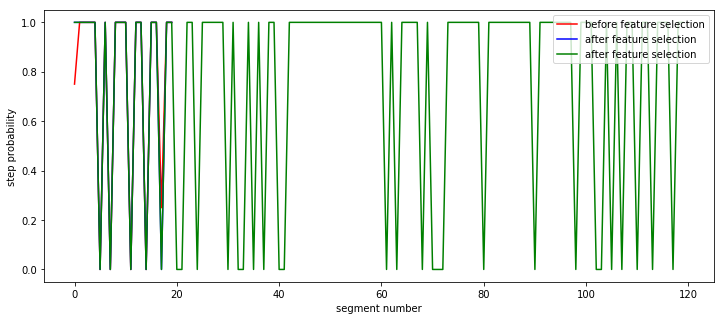

In [14]:
#Load dataset as pandas data frame
filename = "centre_both.csv"
dataset = pd.read_csv(filename)

#Split data into input and output variable
X = dataset.iloc[:,0:dataset.shape[1]-1]
Y = dataset.iloc[:,-1]

X_trainB, X_testB, y_trainB, y_testB = train_test_split(X, Y,test_size=0.7,random_state = 100)
X_trainA, X_testA, y_trainA, y_testA = train_test_split(X, Y,test_size=0.7,random_state = 100)


# Removing Constant features
constant_filter = VarianceThreshold()
constant_filter.fit(X_trainA)
constant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[constant_filter.get_support()]]
X_trainA.drop(labels=constant_columns,axis=1, inplace=True) 
X_testA.drop(labels=constant_columns,axis=1, inplace=True)


RtestB = l202test.copy()
RtestA = l202test.copy()

RtestA.drop(labels=constant_columns,axis=1, inplace=True)

# Removing Quasi-Constant features
qconstant_filter = VarianceThreshold(0.01)
qconstant_filter.fit(X_trainA)
qconstant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[qconstant_filter.get_support()]]
X_trainA.drop(labels=qconstant_columns,axis=1, inplace=True) 
X_testA.drop(labels=qconstant_columns,axis=1, inplace=True)
RtestA.drop(labels=qconstant_columns,axis=1, inplace=True)

# Removing Correlated Features
correlated_features = set()  
correlation_matrix = X_trainA.corr(method = 'pearson')
for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.4:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
X_trainA.drop(labels=correlated_features,axis=1, inplace=True) 
X_testA.drop(labels=correlated_features,axis=1, inplace=True)
RtestA.drop(labels=correlated_features,axis=1, inplace=True)

# feature ranking and selection    
ranking_info, selected_features = feature_ranking_selection(X_trainA, y_trainA, 15)
X_trainA = X_trainA[selected_features]        
X_testA = X_testA[selected_features] 
RtestA = RtestA[selected_features]

#names = ["Nearest Neighbors","Decision Tree","Naive Bayes"]
names = ["Decision Tree"]

classifiers = [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
classifier2= [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
clf_bef = list()
clf_aft = list()

for name, clf, dlf in zip(names,classifiers,classifier2):
      
    
    # Before Feature Selection
    startB = time.time()
    clf.fit(X_trainB,y_trainB)
    #plot_decision_boundary(clf, X = X_train,Y = y_train)
    endB = time.time() 
    clf_bef.append(clf)
   # plot_decision_boundary(clf, X = X_train,Y = y_train)
    
    # after Feature Selection    
    startA = time.time()
    dlf.fit(X_trainA,y_trainA)
    endA = time.time()
    clf_aft.append(dlf)
    #plot_decision_boundary(dlf, X = X_train,Y = y_train)
    
    print('\t\t\t\tClassifier:',name.upper())
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')
         
    print('\t\tBefore Feature Selection\tAfter Feature Selection')
    print('No. of features:\t', X_trainB.shape[1],'\t\t\t',X_trainA.shape[1])
   
    class1B = clf.predict_proba(RtestB)[:,1]
    class1A = dlf.predict_proba(RtestA)[:,1]
    stepB = len(class1B[class1B >0.5])
    stepA = len(class1A[class1A >0.5])
    print('Step Detected:\t\t',stepB,'\t\t\t',stepA)
    print('27 is actual number of step in ID008440 ')
    
    
from sklearn.externals.six import StringIO
import pydotplus
from sklearn.tree import export_graphviz
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
#plt.rcParams.update({'font.size': 26})
# plotting class probabilities
for name, clf, dlf in zip(names, clf_bef, clf_aft):
    # before feature selection
    
    columnsB=list(X_testB.columns)
    dot_data = StringIO()
    export_graphviz(clf,out_file=dot_data,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    graph.write_pdf(filename[:-4] +"_Before.pdf")
    # to display
    display(graphviz.Source(export_graphviz(clf,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)))
    
    # after feature selection
    columnsA=list(X_testA.columns)
    dot_dataA = StringIO()
    export_graphviz(dlf,out_file=dot_dataA,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_dataA.getvalue()) 
    graph.write_pdf(filename[:-4] +"_After.pdf")
    display(graphviz.Source(export_graphviz(dlf,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)))  
         
    class1B = clf.predict_proba(X_testB[20:40])[:,1]
    #print(class1B)
    class1A = dlf.predict_proba(X_testA[20:40])[:,1]
    #print(class1A)
    plt.figure(figsize=(12,5))
   # plt.title('Certainty of a step detecion')
    plt.plot(class1B,label = 'before feature selection', color ='red')
    plt.plot(class1A,label = 'after feature selection',color ='blue')
    plt.plot(y_testB[20:140].values,label = 'after feature selection',color ='green')
    plt.xlabel('segment number')
    plt.ylabel('step probability')
    plt.legend(loc='upper right',ncol=1)
    #plt.savefig('certainty2.pdf', dpi=1500)
    plt.show()
   

In [11]:
y_testB[0:10]

5343     1.0
1750     1.0
2673     1.0
12419    1.0
13498    1.0
4248     0.0
401      0.0
14004    1.0
6585     1.0
3391     1.0
Name: label, dtype: float64

# L202

				Classifier: DECISION TREE
---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
		Before Feature Selection	After Feature Selection
No. of features:	 202 			 15
Step Detected:		 11 			 32
27 is actual number of step in ID008440 


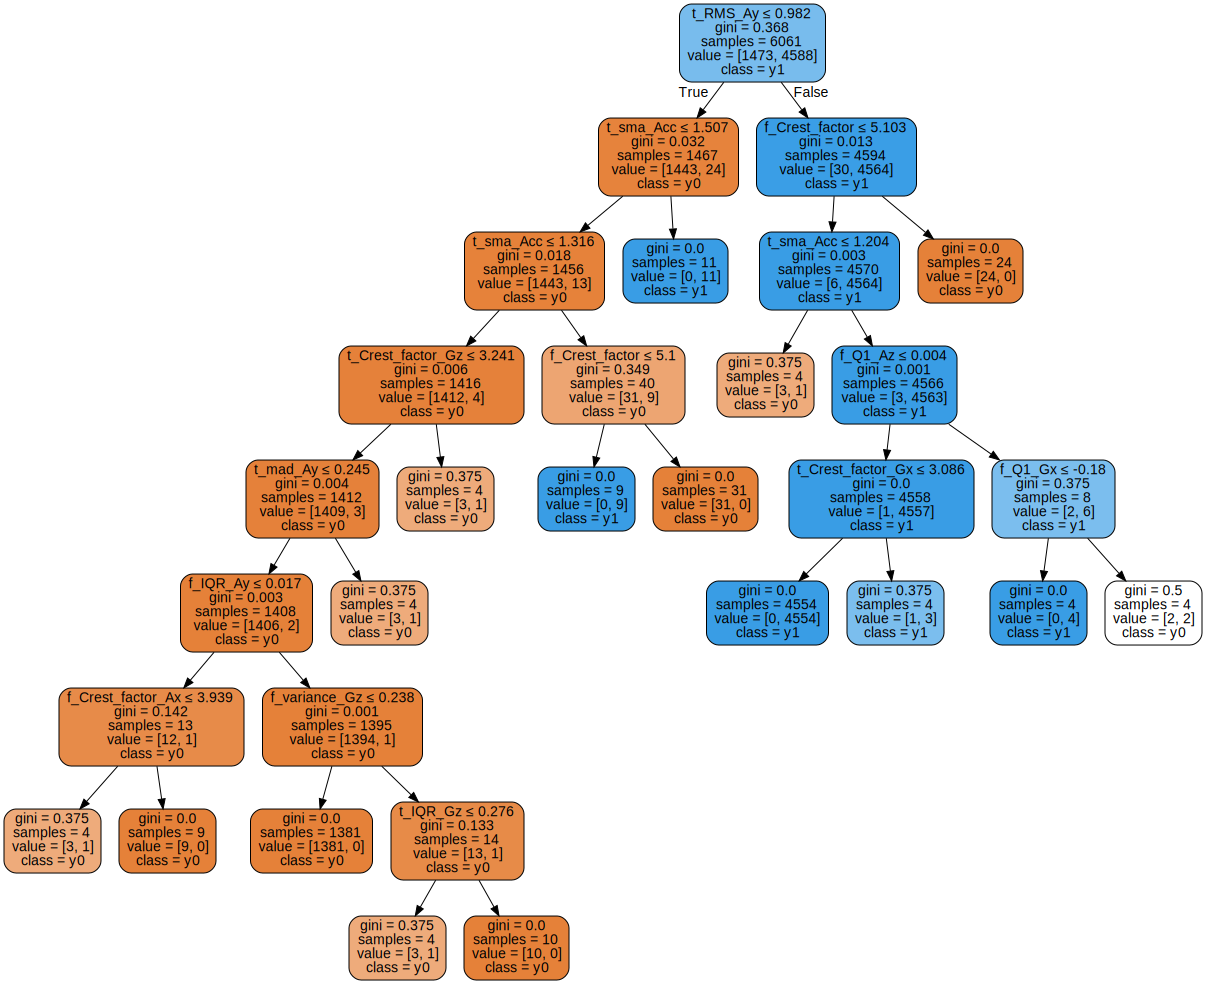

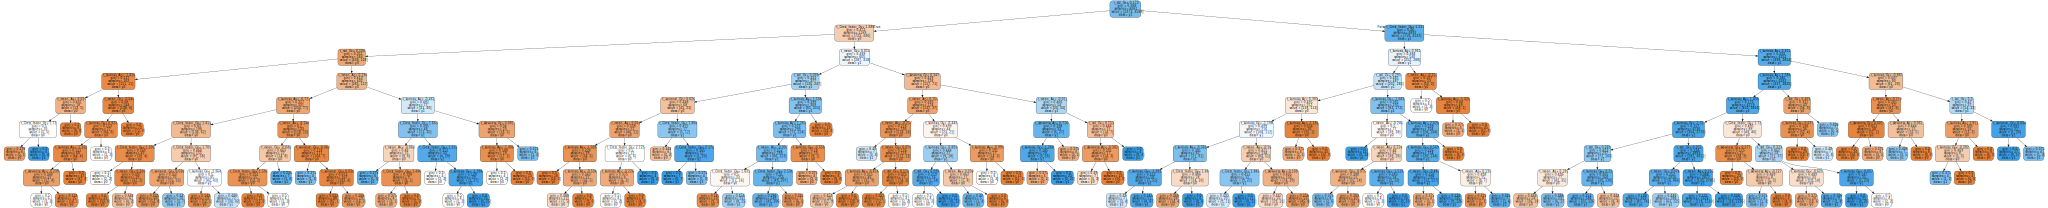

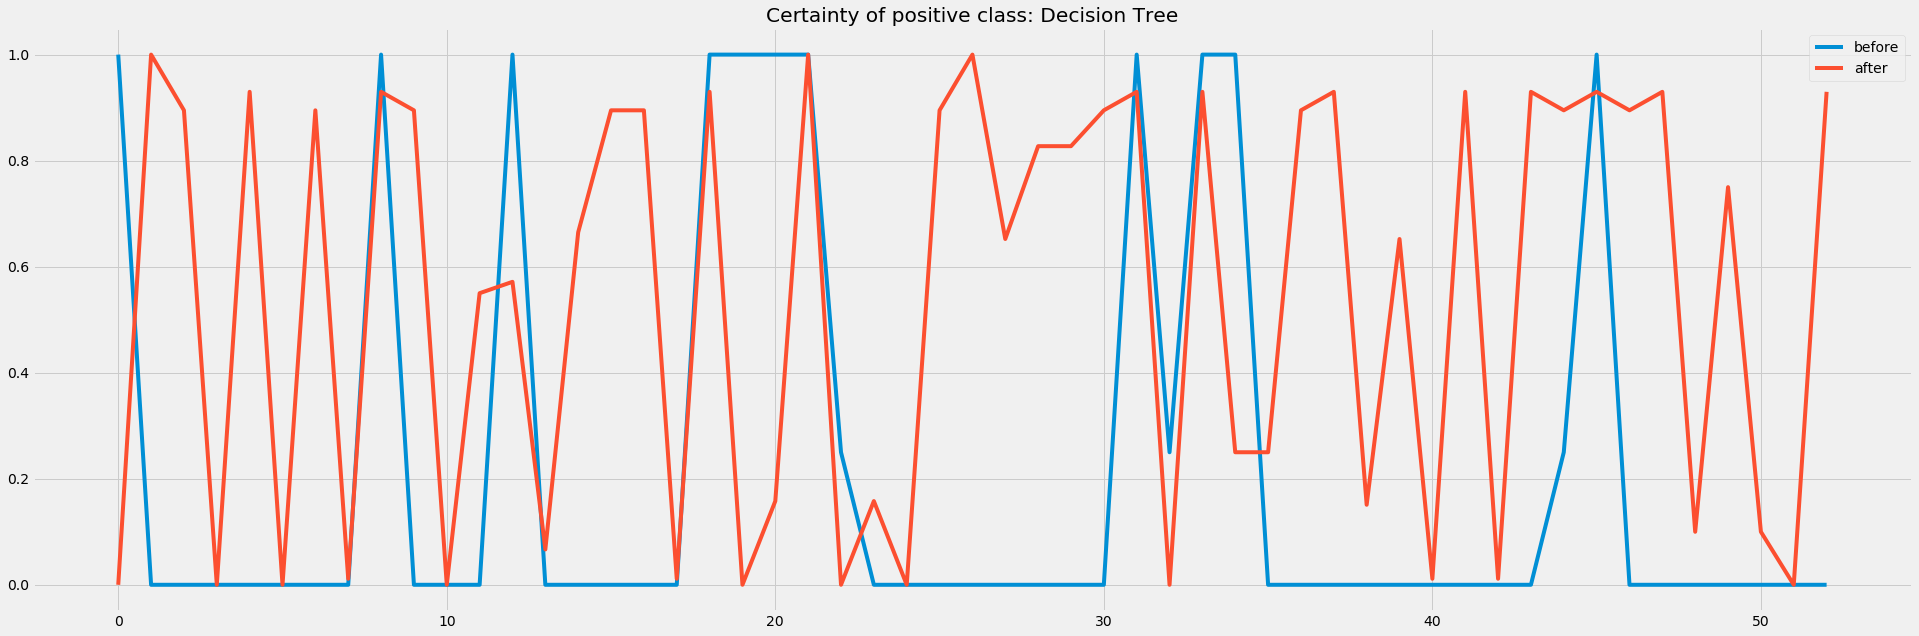

In [18]:
#Load dataset as pandas data frame
filename = 'left_both.csv'
dataset = pd.read_csv(filename)

#Split data into input and output variable
X = dataset.iloc[:,0:dataset.shape[1]-1]
Y = dataset.iloc[:,-1]

X_trainB, X_testB, y_trainB, y_testB = train_test_split(X, Y,test_size=0.7,random_state = 100)
X_trainA, X_testA, y_trainA, y_testA = train_test_split(X, Y,test_size=0.7,random_state = 100)


# Removing Constant features
constant_filter = VarianceThreshold()
constant_filter.fit(X_trainA)
constant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[constant_filter.get_support()]]
X_trainA.drop(labels=constant_columns,axis=1, inplace=True) 
X_testA.drop(labels=constant_columns,axis=1, inplace=True)


RtestB = l202test.copy()
RtestA = l202test.copy()

RtestA.drop(labels=constant_columns,axis=1, inplace=True)

# Removing Quasi-Constant features
qconstant_filter = VarianceThreshold(0.01)
qconstant_filter.fit(X_trainA)
qconstant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[qconstant_filter.get_support()]]
X_trainA.drop(labels=qconstant_columns,axis=1, inplace=True) 
X_testA.drop(labels=qconstant_columns,axis=1, inplace=True)
RtestA.drop(labels=qconstant_columns,axis=1, inplace=True)

# Removing Correlated Features
correlated_features = set()  
correlation_matrix = X_trainA.corr(method = 'pearson')
for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.4:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
X_trainA.drop(labels=correlated_features,axis=1, inplace=True) 
X_testA.drop(labels=correlated_features,axis=1, inplace=True)
RtestA.drop(labels=correlated_features,axis=1, inplace=True)

# feature ranking and selection    
ranking_info, selected_features = feature_ranking_selection(X_trainA, y_trainA, 15)
X_trainA = X_trainA[selected_features]        
X_testA = X_testA[selected_features] 
RtestA = RtestA[selected_features]

#names = ["Nearest Neighbors","Decision Tree","Naive Bayes"]
names = ["Decision Tree"]

classifiers = [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
classifier2= [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
clf_bef = list()
clf_aft = list()

for name, clf, dlf in zip(names,classifiers,classifier2):
      
    
    # Before Feature Selection
    startB = time.time()
    clf.fit(X_trainB,y_trainB)
    #plot_decision_boundary(clf, X = X_train,Y = y_train)
    endB = time.time() 
    clf_bef.append(clf)
   # plot_decision_boundary(clf, X = X_train,Y = y_train)
    
    # after Feature Selection    
    startA = time.time()
    dlf.fit(X_trainA,y_trainA)
    endA = time.time()
    clf_aft.append(dlf)
    #plot_decision_boundary(dlf, X = X_train,Y = y_train)
    
    print('\t\t\t\tClassifier:',name.upper())
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')
         
    print('\t\tBefore Feature Selection\tAfter Feature Selection')
    print('No. of features:\t', X_trainB.shape[1],'\t\t\t',X_trainA.shape[1])
   
    class1B = clf.predict_proba(RtestB)[:,1]
    class1A = dlf.predict_proba(RtestA)[:,1]
    stepB = len(class1B[class1B >0.5])
    stepA = len(class1A[class1A >0.5])
    print('Step Detected:\t\t',stepB,'\t\t\t',stepA)
    print('27 is actual number of step in ID008440 ')
    
    
from sklearn.externals.six import StringIO
import pydotplus
from sklearn.tree import export_graphviz
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
plt.rcParams.update({'font.size': 26})
# plotting class probabilities
for name, clf, dlf in zip(names, clf_bef, clf_aft):
    # before feature selection
    
    columnsB=list(X_testB.columns)
    dot_data = StringIO()
    export_graphviz(clf,out_file=dot_data,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    graph.write_pdf(filename[:-4] +"_Before.pdf")
    # to display
    display(graphviz.Source(export_graphviz(clf,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)))
    
    # after feature selection
    columnsA=list(X_testA.columns)
    dot_dataA = StringIO()
    export_graphviz(dlf,out_file=dot_dataA,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_dataA.getvalue()) 
    graph.write_pdf(filename[:-4] +"_After.pdf")
    display(graphviz.Source(export_graphviz(dlf,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)))  
         
    class1B = clf.predict_proba(RtestB)[:,1]
    #print(class1B)
    class1A = dlf.predict_proba(RtestA)[:,1]
    #print(class1A)
    plt.figure(figsize=(10.5, 4.5))
    plt.title('Certainty of positive class: '+ name)
    plt.plot(class1B,label = 'before')
    plt.plot(class1A,label = 'after')
    plt.legend(loc='upper right',ncol=1)
    plt.savefig('certainty.pdf', dpi=1500)
    plt.show()

# R202

				Classifier: DECISION TREE
---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
		Before Feature Selection	After Feature Selection
No. of features:	 202 			 15
Step Detected:		 11 			 29
27 is actual number of step in ID008440 


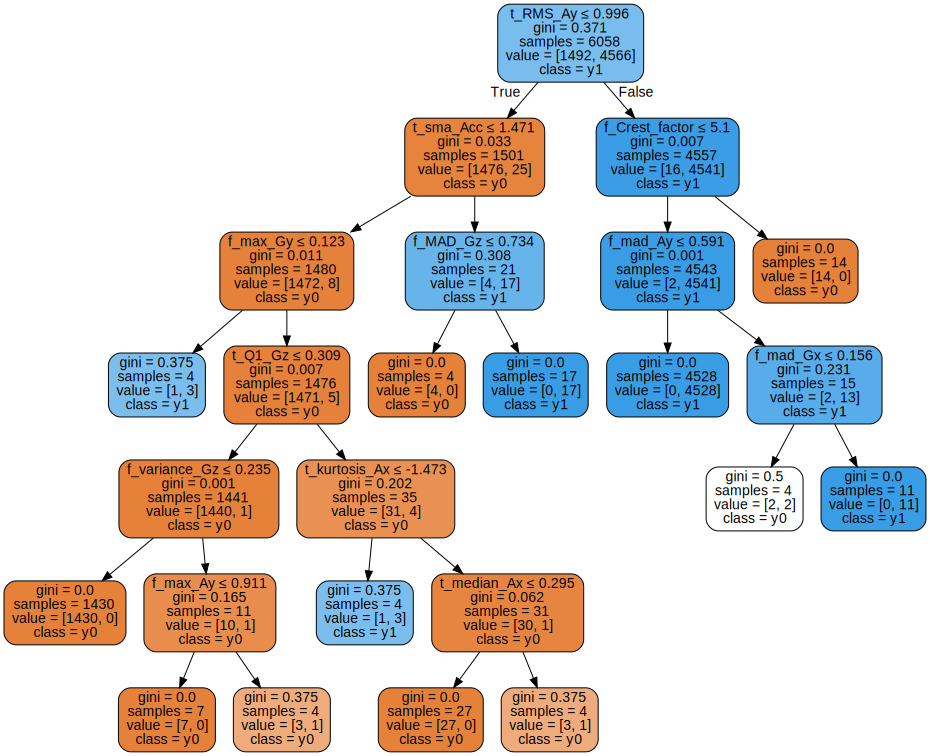

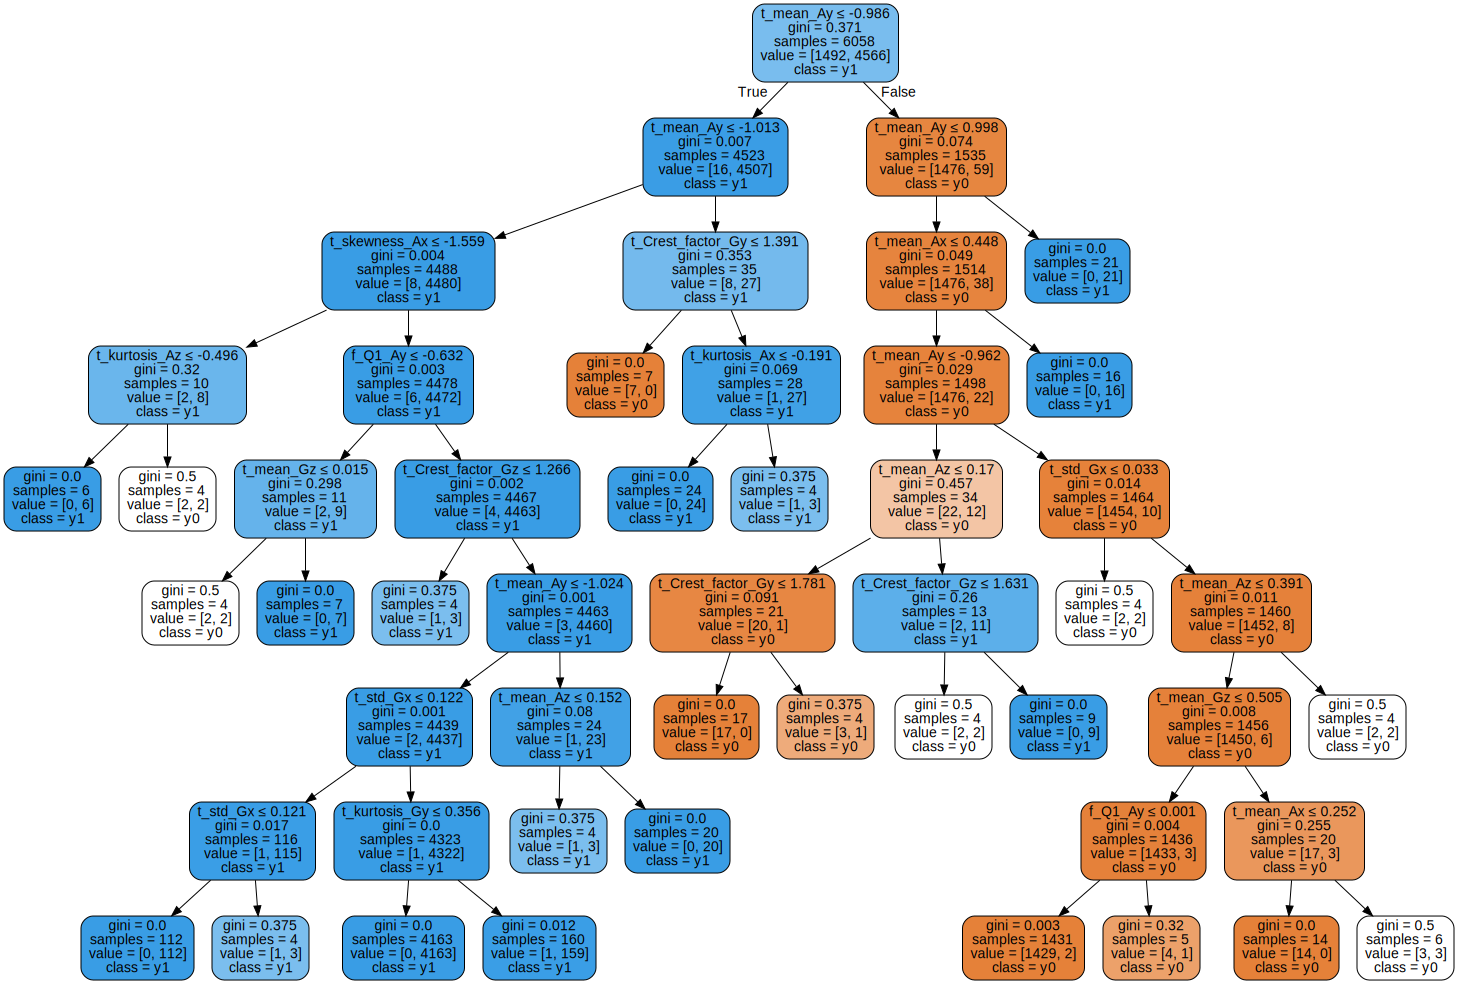

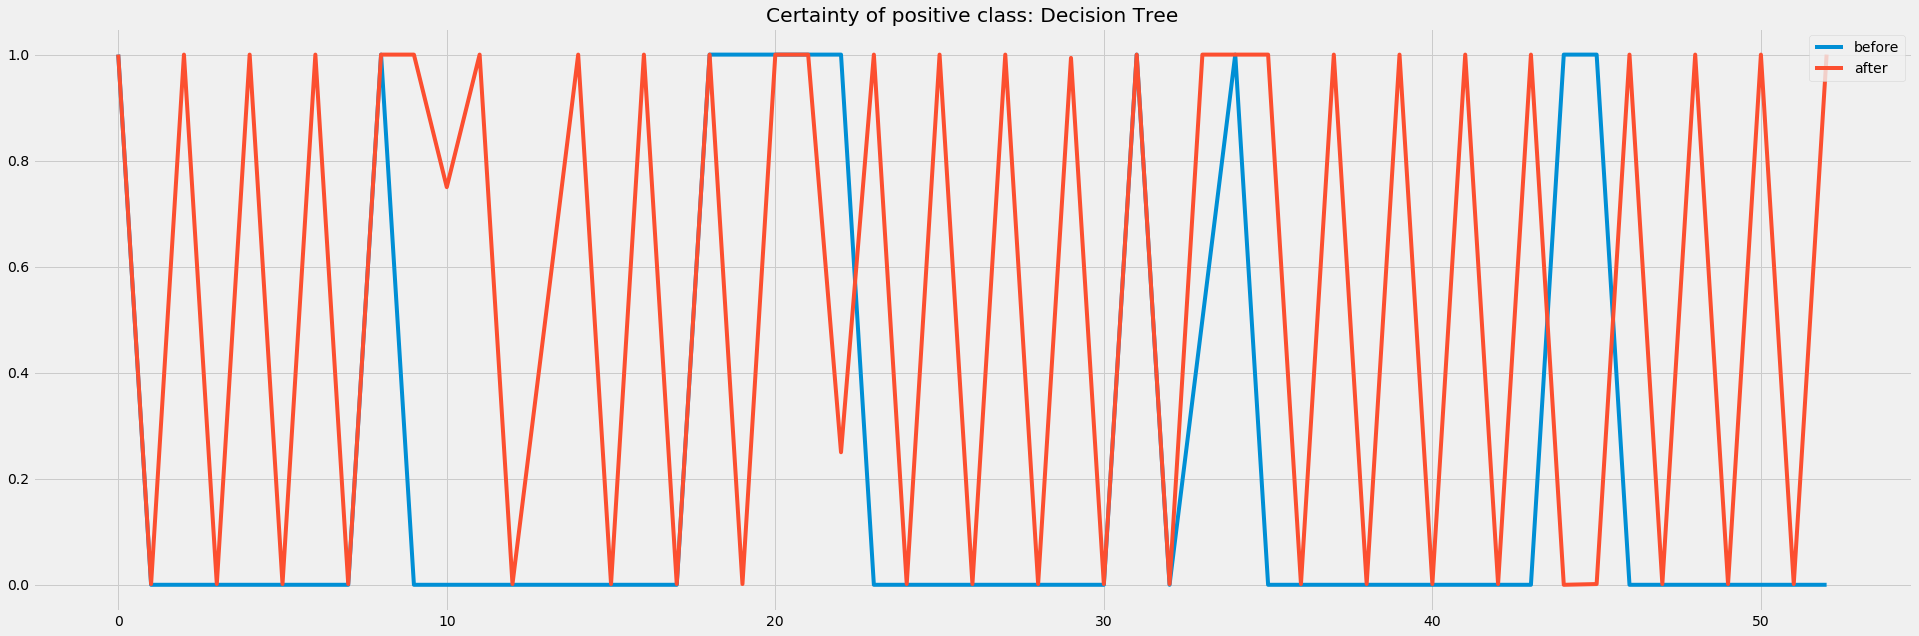

In [26]:
#Load dataset as pandas data frame
filename = 'right_both.csv'
dataset = pd.read_csv(filename)

#Split data into input and output variable
X = dataset.iloc[:,0:dataset.shape[1]-1]
Y = dataset.iloc[:,-1]

X_trainB, X_testB, y_trainB, y_testB = train_test_split(X, Y,test_size=0.7,random_state = 100)
X_trainA, X_testA, y_trainA, y_testA = train_test_split(X, Y,test_size=0.7,random_state = 100)


# Removing Constant features
constant_filter = VarianceThreshold()
constant_filter.fit(X_trainA)
constant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[constant_filter.get_support()]]
X_trainA.drop(labels=constant_columns,axis=1, inplace=True) 
X_testA.drop(labels=constant_columns,axis=1, inplace=True)


RtestB = l202test.copy()
RtestA = l202test.copy()

RtestA.drop(labels=constant_columns,axis=1, inplace=True)

# Removing Quasi-Constant features
qconstant_filter = VarianceThreshold(0.01)
qconstant_filter.fit(X_trainA)
qconstant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[qconstant_filter.get_support()]]
X_trainA.drop(labels=qconstant_columns,axis=1, inplace=True) 
X_testA.drop(labels=qconstant_columns,axis=1, inplace=True)
RtestA.drop(labels=qconstant_columns,axis=1, inplace=True)

# Removing Correlated Features
correlated_features = set()  
correlation_matrix = X_trainA.corr(method = 'pearson')
for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.4:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
X_trainA.drop(labels=correlated_features,axis=1, inplace=True) 
X_testA.drop(labels=correlated_features,axis=1, inplace=True)
RtestA.drop(labels=correlated_features,axis=1, inplace=True)

# feature ranking and selection    
ranking_info, selected_features = feature_ranking_selection(X_trainA, y_trainA, 15)
X_trainA = X_trainA[selected_features]        
X_testA = X_testA[selected_features] 
RtestA = RtestA[selected_features]

#names = ["Nearest Neighbors","Decision Tree","Naive Bayes"]
names = ["Decision Tree"]

classifiers = [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
classifier2= [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
clf_bef = list()
clf_aft = list()

for name, clf, dlf in zip(names,classifiers,classifier2):
      
    
    # Before Feature Selection
    startB = time.time()
    clf.fit(X_trainB,y_trainB)
    #plot_decision_boundary(clf, X = X_train,Y = y_train)
    endB = time.time() 
    clf_bef.append(clf)
   # plot_decision_boundary(clf, X = X_train,Y = y_train)
    
    # after Feature Selection    
    startA = time.time()
    dlf.fit(X_trainA,y_trainA)
    endA = time.time()
    clf_aft.append(dlf)
    #plot_decision_boundary(dlf, X = X_train,Y = y_train)
    
    print('\t\t\t\tClassifier:',name.upper())
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')
         
    print('\t\tBefore Feature Selection\tAfter Feature Selection')
    print('No. of features:\t', X_trainB.shape[1],'\t\t\t',X_trainA.shape[1])
   
    class1B = clf.predict_proba(RtestB)[:,1]
    class1A = dlf.predict_proba(RtestA)[:,1]
    stepB = len(class1B[class1B >0.5])
    stepA = len(class1A[class1A >0.5])
    print('Step Detected:\t\t',stepB,'\t\t\t',stepA)
    print('27 is actual number of step in ID008440 ')
    
    
from sklearn.externals.six import StringIO
import pydotplus
from sklearn.tree import export_graphviz
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# plotting class probabilities
for name, clf, dlf in zip(names, clf_bef, clf_aft):
    # before feature selection
    
    columnsB=list(X_testB.columns)
    dot_data = StringIO()
    export_graphviz(clf,out_file=dot_data,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    graph.write_pdf(filename[:-4] +"_Before.pdf")
    # to display
    display(graphviz.Source(export_graphviz(clf,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)))
    
    # after feature selection
    columnsA=list(X_testA.columns)
    dot_dataA = StringIO()
    export_graphviz(dlf,out_file=dot_dataA,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_dataA.getvalue()) 
    graph.write_pdf(filename[:-4] +"_After.pdf")
    display(graphviz.Source(export_graphviz(dlf,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)))  
         
    class1B = clf.predict_proba(RtestB)[:,1]
    #print(class1B)
    class1A = dlf.predict_proba(RtestA)[:,1]
    #print(class1A)
    plt.figure(figsize=(30,10))
    plt.title('Certainty of positive class: '+ name)
    plt.plot(class1B,label = 'before')
    plt.plot(class1A,label = 'after')
    plt.legend(loc='upper right',ncol=1)
    plt.show()
   

# CL202

				Classifier: DECISION TREE
---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
		Before Feature Selection	After Feature Selection
No. of features:	 202 			 15
Step Detected:		 11 			 29
27 is actual number of step in ID008440 


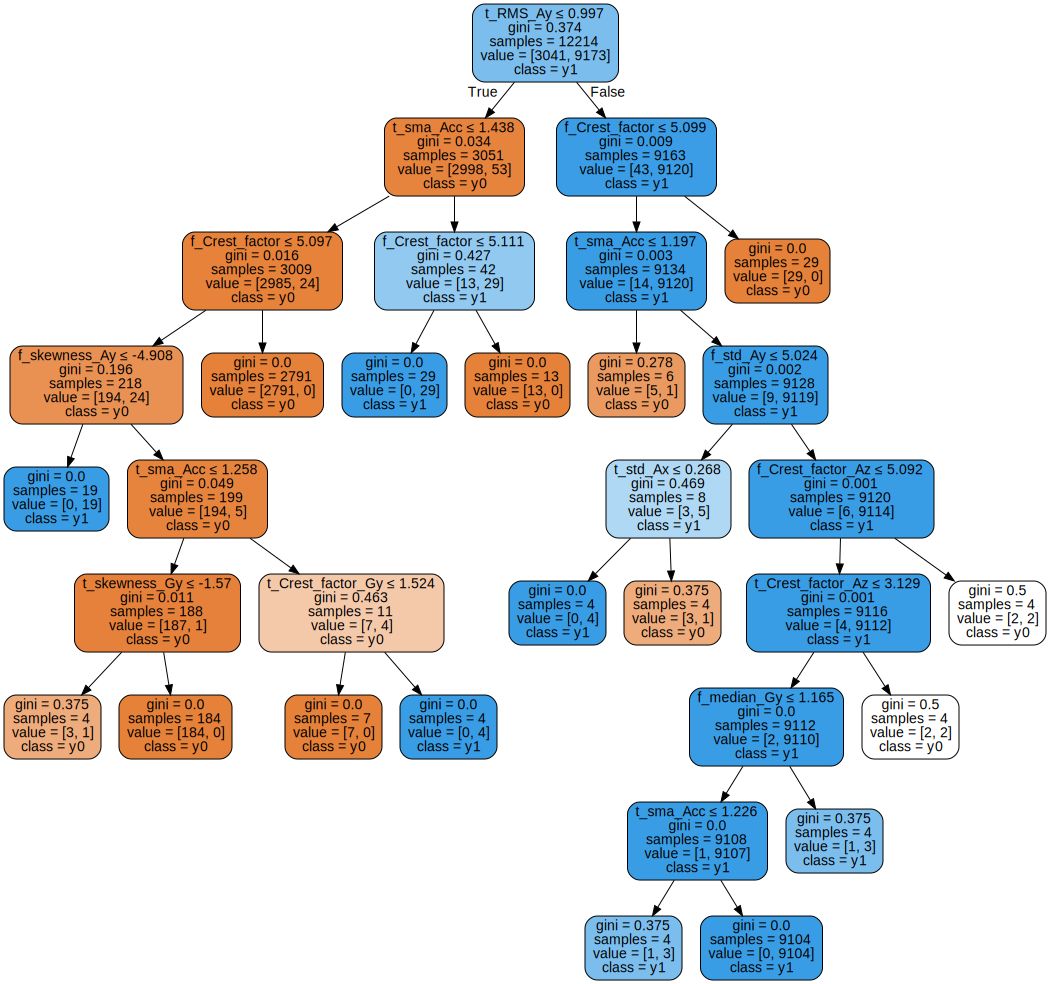

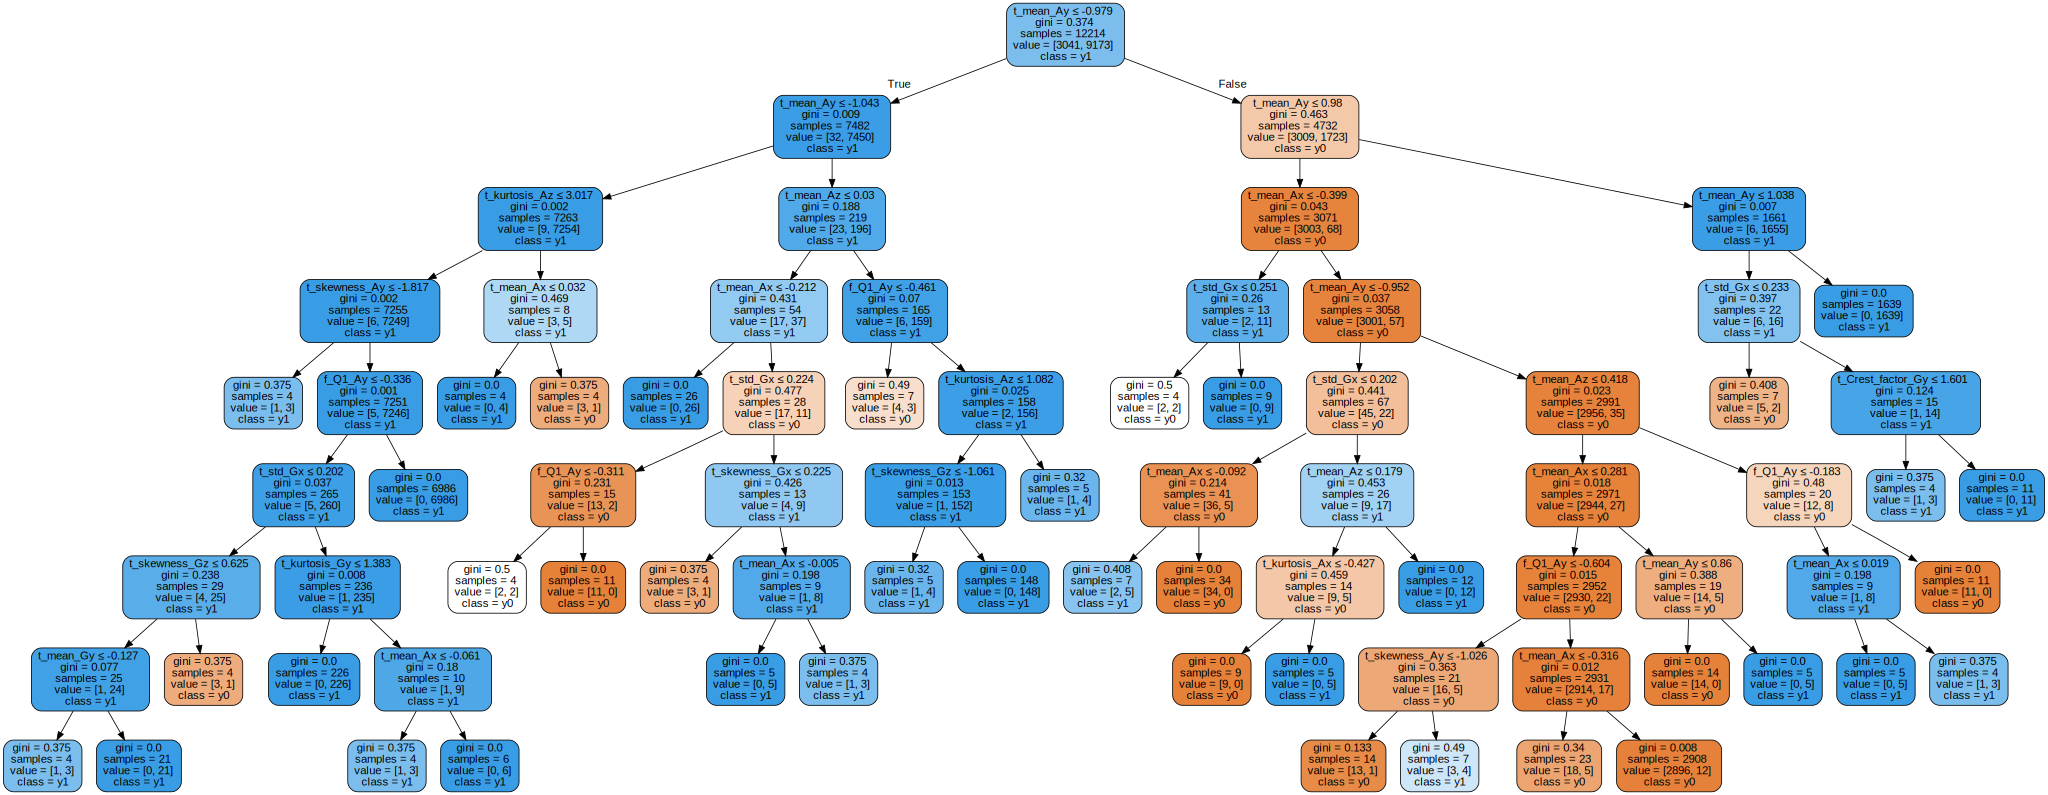

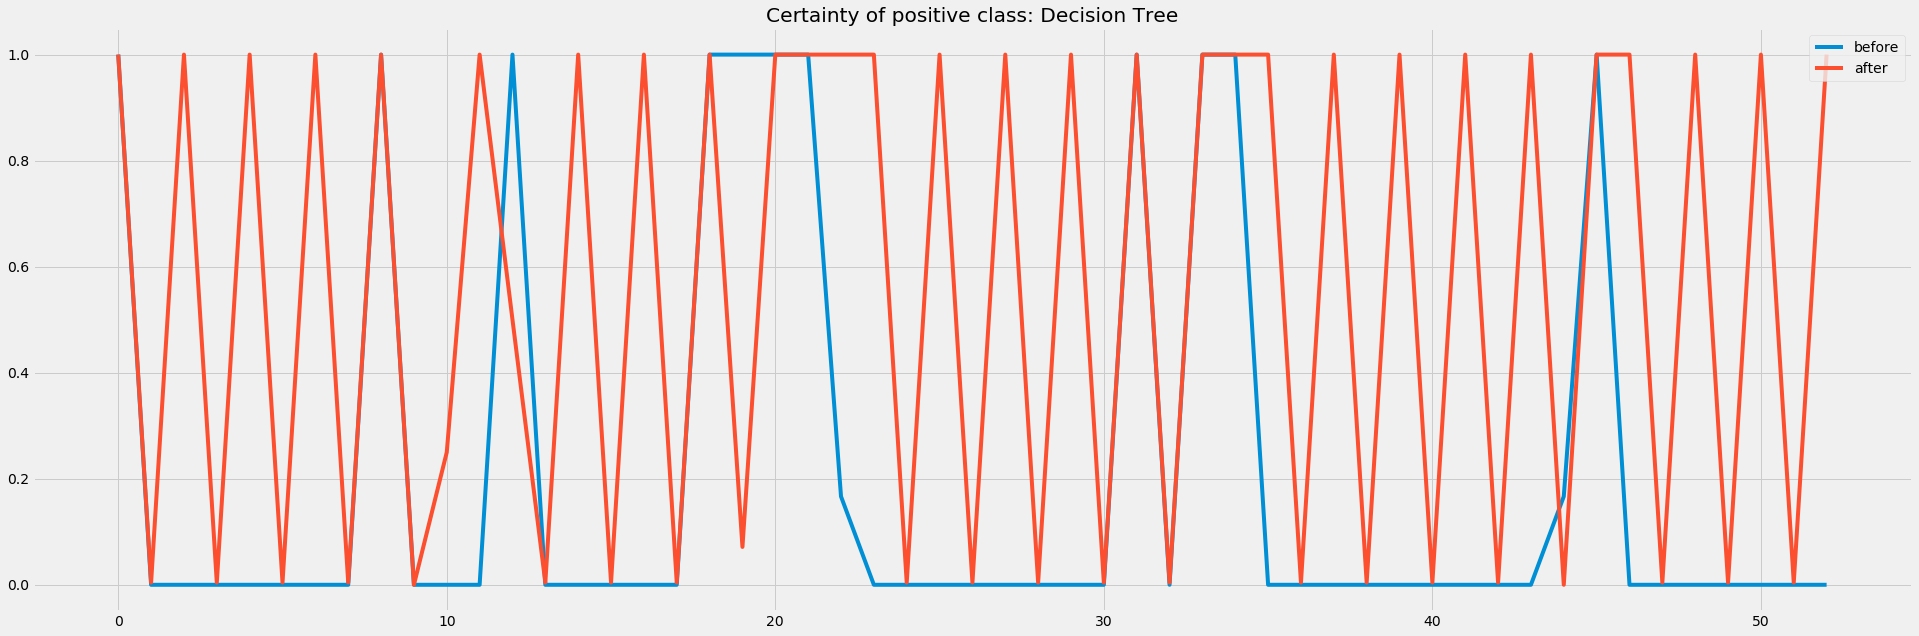

In [19]:
#Load dataset as pandas data frame
filename = 'CL_both_202.csv'
dataset = pd.read_csv(filename)

#Split data into input and output variable
X = dataset.iloc[:,0:dataset.shape[1]-1]
Y = dataset.iloc[:,-1]

X_trainB, X_testB, y_trainB, y_testB = train_test_split(X, Y,test_size=0.7,random_state = 100)
X_trainA, X_testA, y_trainA, y_testA = train_test_split(X, Y,test_size=0.7,random_state = 100)


# Removing Constant features
constant_filter = VarianceThreshold()
constant_filter.fit(X_trainA)
constant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[constant_filter.get_support()]]
X_trainA.drop(labels=constant_columns,axis=1, inplace=True) 
X_testA.drop(labels=constant_columns,axis=1, inplace=True)


RtestB = l202test.copy()
RtestA = l202test.copy()

RtestA.drop(labels=constant_columns,axis=1, inplace=True)

# Removing Quasi-Constant features
qconstant_filter = VarianceThreshold(0.01)
qconstant_filter.fit(X_trainA)
qconstant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[qconstant_filter.get_support()]]
X_trainA.drop(labels=qconstant_columns,axis=1, inplace=True) 
X_testA.drop(labels=qconstant_columns,axis=1, inplace=True)
RtestA.drop(labels=qconstant_columns,axis=1, inplace=True)

# Removing Correlated Features
correlated_features = set()  
correlation_matrix = X_trainA.corr(method = 'pearson')
for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.4:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
X_trainA.drop(labels=correlated_features,axis=1, inplace=True) 
X_testA.drop(labels=correlated_features,axis=1, inplace=True)
RtestA.drop(labels=correlated_features,axis=1, inplace=True)

# feature ranking and selection    
ranking_info, selected_features = feature_ranking_selection(X_trainA, y_trainA, 15)
X_trainA = X_trainA[selected_features]        
X_testA = X_testA[selected_features] 
RtestA = RtestA[selected_features]

#names = ["Nearest Neighbors","Decision Tree","Naive Bayes"]
names = ["Decision Tree"]

classifiers = [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
classifier2= [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
clf_bef = list()
clf_aft = list()

for name, clf, dlf in zip(names,classifiers,classifier2):
      
    
    # Before Feature Selection
    startB = time.time()
    clf.fit(X_trainB,y_trainB)
    #plot_decision_boundary(clf, X = X_train,Y = y_train)
    endB = time.time() 
    clf_bef.append(clf)
   # plot_decision_boundary(clf, X = X_train,Y = y_train)
    
    # after Feature Selection    
    startA = time.time()
    dlf.fit(X_trainA,y_trainA)
    endA = time.time()
    clf_aft.append(dlf)
    #plot_decision_boundary(dlf, X = X_train,Y = y_train)
    
    print('\t\t\t\tClassifier:',name.upper())
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')
         
    print('\t\tBefore Feature Selection\tAfter Feature Selection')
    print('No. of features:\t', X_trainB.shape[1],'\t\t\t',X_trainA.shape[1])
   
    class1B = clf.predict_proba(RtestB)[:,1]
    class1A = dlf.predict_proba(RtestA)[:,1]
    stepB = len(class1B[class1B >0.5])
    stepA = len(class1A[class1A >0.5])
    print('Step Detected:\t\t',stepB,'\t\t\t',stepA)
    print('27 is actual number of step in ID008440 ')
    
    
from sklearn.externals.six import StringIO
import pydotplus
from sklearn.tree import export_graphviz
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# plotting class probabilities
for name, clf, dlf in zip(names, clf_bef, clf_aft):
    # before feature selection
    
    columnsB=list(X_testB.columns)
    dot_data = StringIO()
    export_graphviz(clf,out_file=dot_data,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    graph.write_pdf(filename[:-4] +"_Before.pdf")
    # to display
    display(graphviz.Source(export_graphviz(clf,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)))
    
    # after feature selection
    columnsA=list(X_testA.columns)
    dot_dataA = StringIO()
    export_graphviz(dlf,out_file=dot_dataA,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_dataA.getvalue()) 
    graph.write_pdf(filename[:-4] +"_After.pdf")
    display(graphviz.Source(export_graphviz(dlf,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)))  
         
    class1B = clf.predict_proba(RtestB)[:,1]
    #print(class1B)
    class1A = dlf.predict_proba(RtestA)[:,1]
    #print(class1A)
    plt.figure(figsize=(30,10))
    plt.title('Certainty of positive class: '+ name)
    plt.plot(class1B,label = 'before')
    plt.plot(class1A,label = 'after')
    plt.legend(loc='upper right',ncol=1)
    plt.show()

# CR202

				Classifier: DECISION TREE
---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
		Before Feature Selection	After Feature Selection
No. of features:	 202 			 15
Step Detected:		 10 			 30
27 is actual number of step in ID008440 


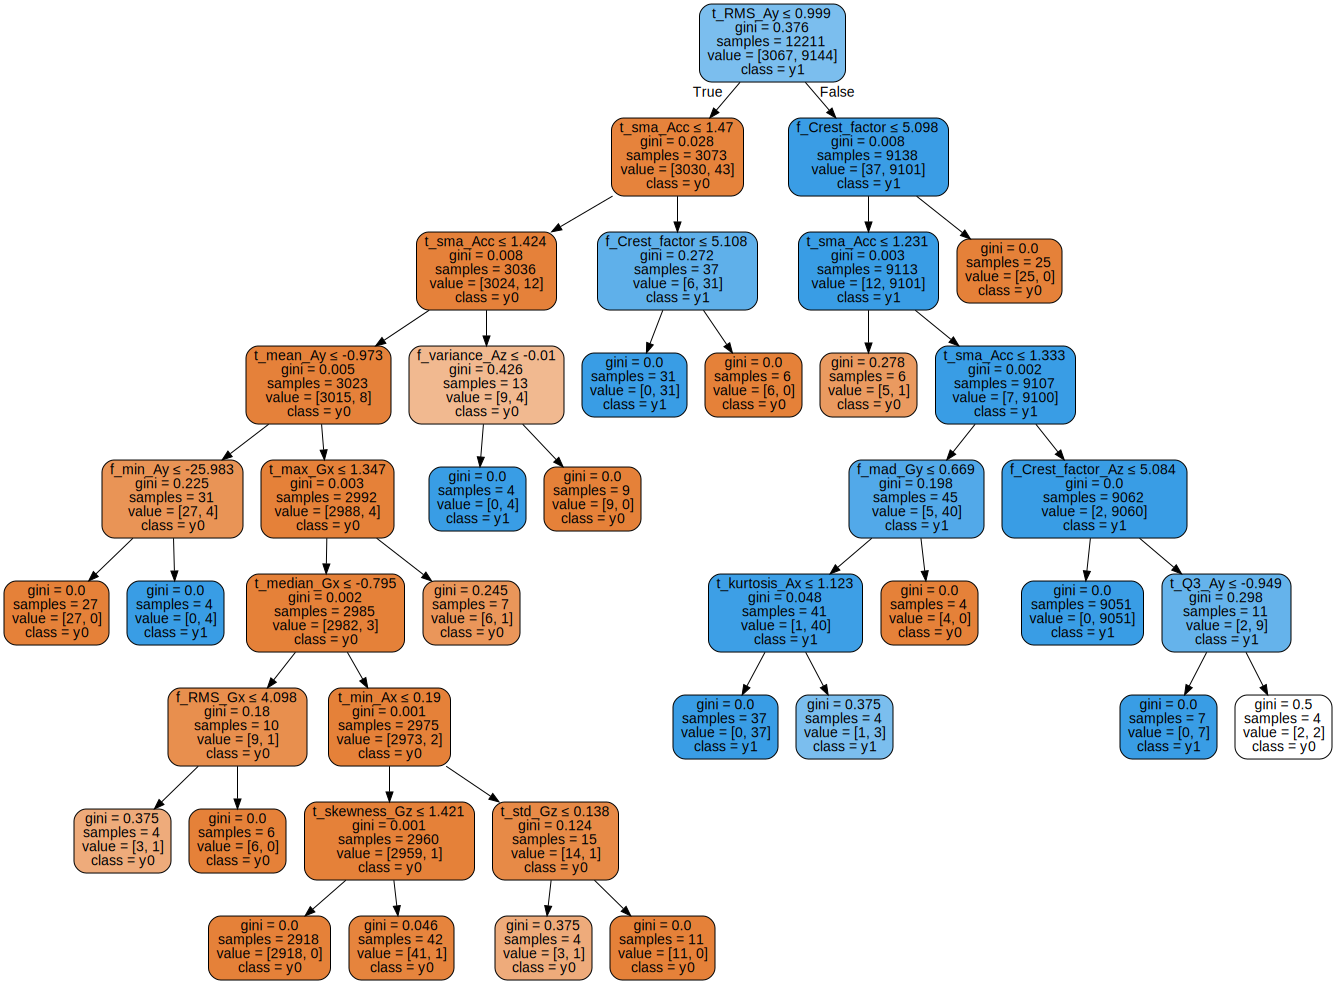

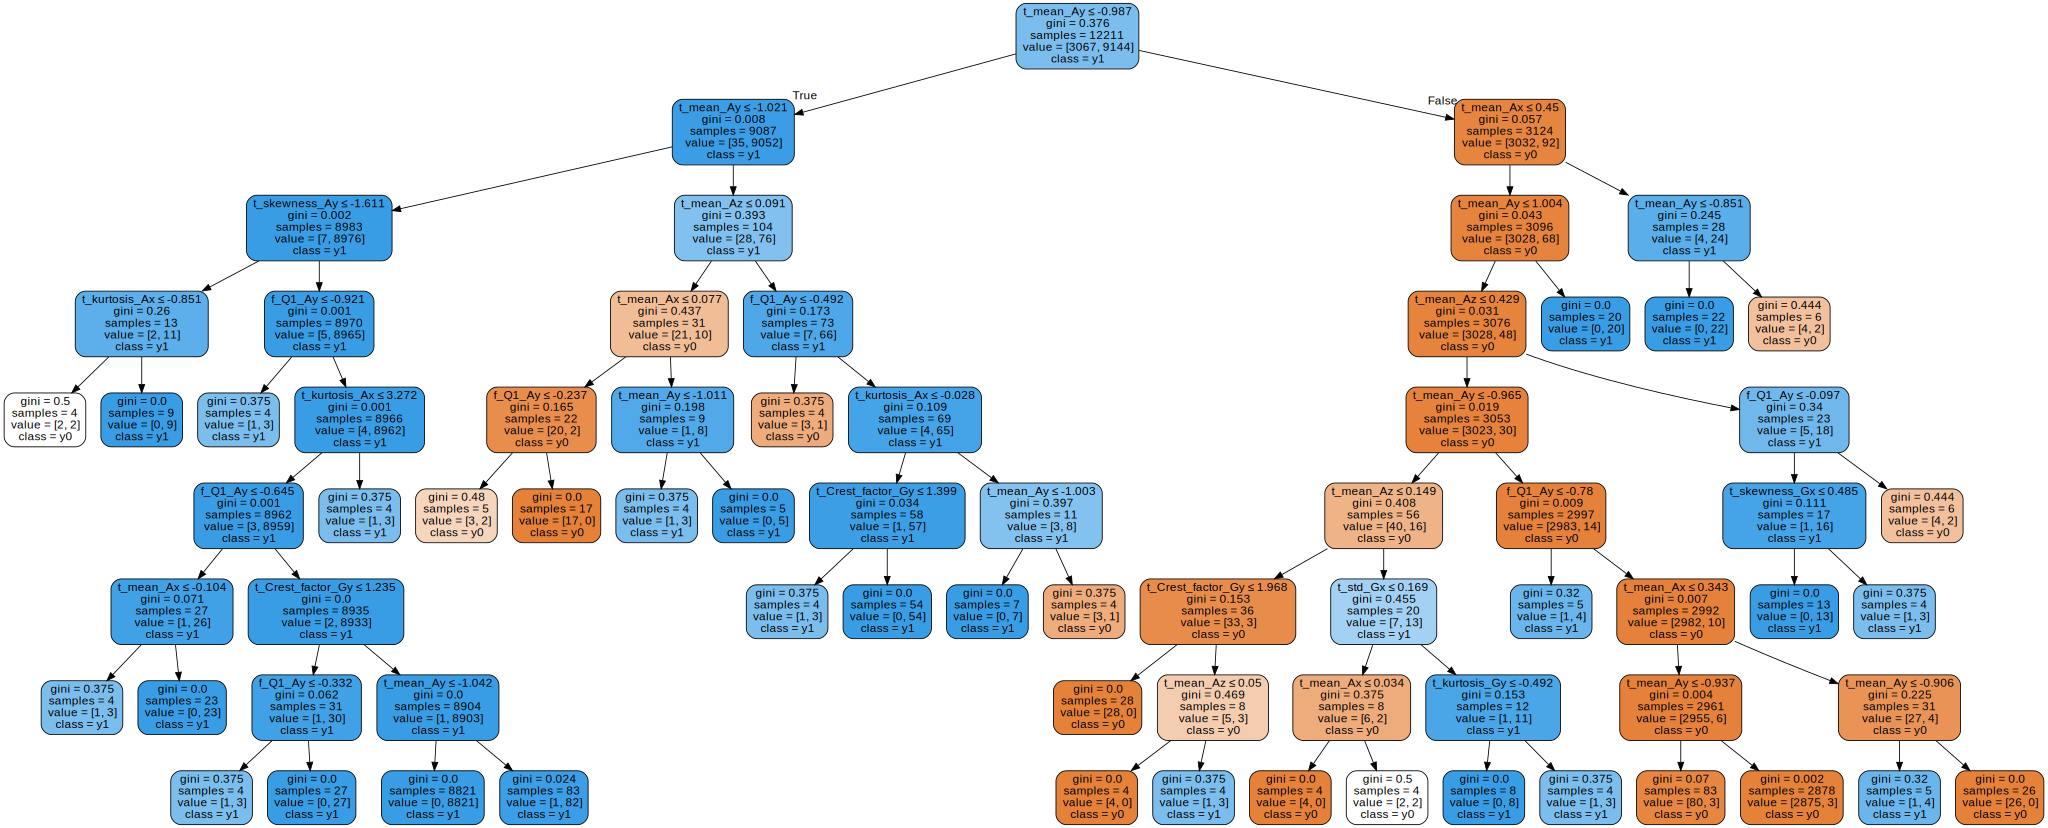

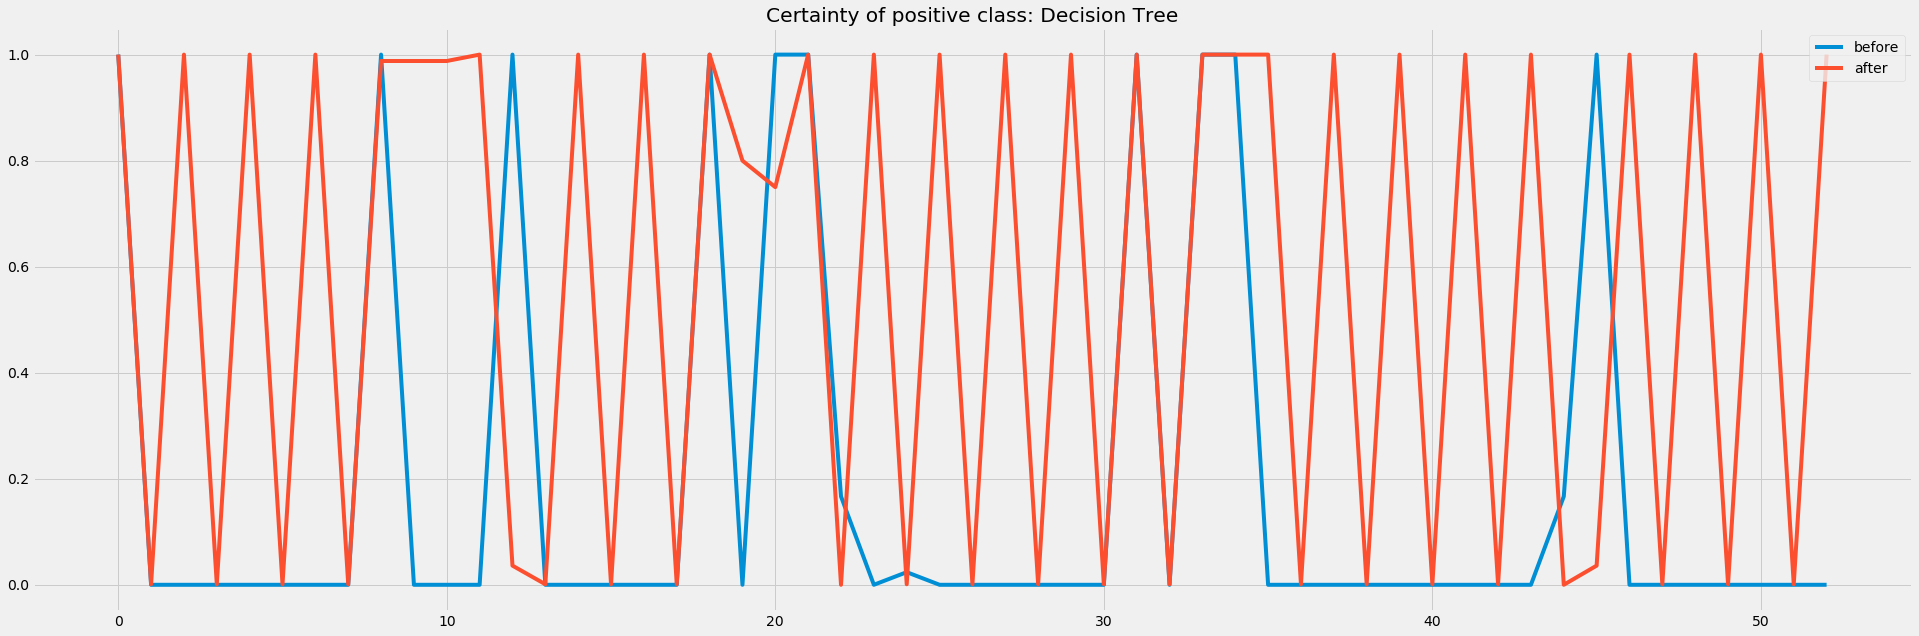

In [20]:
#Load dataset as pandas data frame
filename = 'CR_both_202.csv'
dataset = pd.read_csv(filename)

#Split data into input and output variable
X = dataset.iloc[:,0:dataset.shape[1]-1]
Y = dataset.iloc[:,-1]

X_trainB, X_testB, y_trainB, y_testB = train_test_split(X, Y,test_size=0.7,random_state = 100)
X_trainA, X_testA, y_trainA, y_testA = train_test_split(X, Y,test_size=0.7,random_state = 100)


# Removing Constant features
constant_filter = VarianceThreshold()
constant_filter.fit(X_trainA)
constant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[constant_filter.get_support()]]
X_trainA.drop(labels=constant_columns,axis=1, inplace=True) 
X_testA.drop(labels=constant_columns,axis=1, inplace=True)


RtestB = l202test.copy()
RtestA = l202test.copy()

RtestA.drop(labels=constant_columns,axis=1, inplace=True)

# Removing Quasi-Constant features
qconstant_filter = VarianceThreshold(0.01)
qconstant_filter.fit(X_trainA)
qconstant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[qconstant_filter.get_support()]]
X_trainA.drop(labels=qconstant_columns,axis=1, inplace=True) 
X_testA.drop(labels=qconstant_columns,axis=1, inplace=True)
RtestA.drop(labels=qconstant_columns,axis=1, inplace=True)

# Removing Correlated Features
correlated_features = set()  
correlation_matrix = X_trainA.corr(method = 'pearson')
for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.4:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
X_trainA.drop(labels=correlated_features,axis=1, inplace=True) 
X_testA.drop(labels=correlated_features,axis=1, inplace=True)
RtestA.drop(labels=correlated_features,axis=1, inplace=True)

# feature ranking and selection    
ranking_info, selected_features = feature_ranking_selection(X_trainA, y_trainA, 15)
X_trainA = X_trainA[selected_features]        
X_testA = X_testA[selected_features] 
RtestA = RtestA[selected_features]

#names = ["Nearest Neighbors","Decision Tree","Naive Bayes"]
names = ["Decision Tree"]

classifiers = [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
classifier2= [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
clf_bef = list()
clf_aft = list()

for name, clf, dlf in zip(names,classifiers,classifier2):
      
    
    # Before Feature Selection
    startB = time.time()
    clf.fit(X_trainB,y_trainB)
    #plot_decision_boundary(clf, X = X_train,Y = y_train)
    endB = time.time() 
    clf_bef.append(clf)
   # plot_decision_boundary(clf, X = X_train,Y = y_train)
    
    # after Feature Selection    
    startA = time.time()
    dlf.fit(X_trainA,y_trainA)
    endA = time.time()
    clf_aft.append(dlf)
    #plot_decision_boundary(dlf, X = X_train,Y = y_train)
    
    print('\t\t\t\tClassifier:',name.upper())
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')
         
    print('\t\tBefore Feature Selection\tAfter Feature Selection')
    print('No. of features:\t', X_trainB.shape[1],'\t\t\t',X_trainA.shape[1])
   
    class1B = clf.predict_proba(RtestB)[:,1]
    class1A = dlf.predict_proba(RtestA)[:,1]
    stepB = len(class1B[class1B >0.5])
    stepA = len(class1A[class1A >0.5])
    print('Step Detected:\t\t',stepB,'\t\t\t',stepA)
    print('27 is actual number of step in ID008440 ')
    
    
from sklearn.externals.six import StringIO
import pydotplus
from sklearn.tree import export_graphviz
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# plotting class probabilities
for name, clf, dlf in zip(names, clf_bef, clf_aft):
    # before feature selection
    
    columnsB=list(X_testB.columns)
    dot_data = StringIO()
    export_graphviz(clf,out_file=dot_data,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    graph.write_pdf(filename[:-4] +"_Before.pdf")
    # to display
    display(graphviz.Source(export_graphviz(clf,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)))
    
    # after feature selection
    columnsA=list(X_testA.columns)
    dot_dataA = StringIO()
    export_graphviz(dlf,out_file=dot_dataA,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_dataA.getvalue()) 
    graph.write_pdf(filename[:-4] +"_After.pdf")
    display(graphviz.Source(export_graphviz(dlf,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)))  
         
    class1B = clf.predict_proba(RtestB)[:,1]
    #print(class1B)
    class1A = dlf.predict_proba(RtestA)[:,1]
    #print(class1A)
    plt.figure(figsize=(30,10))
    plt.title('Certainty of positive class: '+ name)
    plt.plot(class1B,label = 'before')
    plt.plot(class1A,label = 'after')
    plt.legend(loc='upper right',ncol=1)
    plt.show()
   

# LR202

				Classifier: DECISION TREE
---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
		Before Feature Selection	After Feature Selection
No. of features:	 202 			 15
Step Detected:		 10 			 32
27 is actual number of step in ID008440 


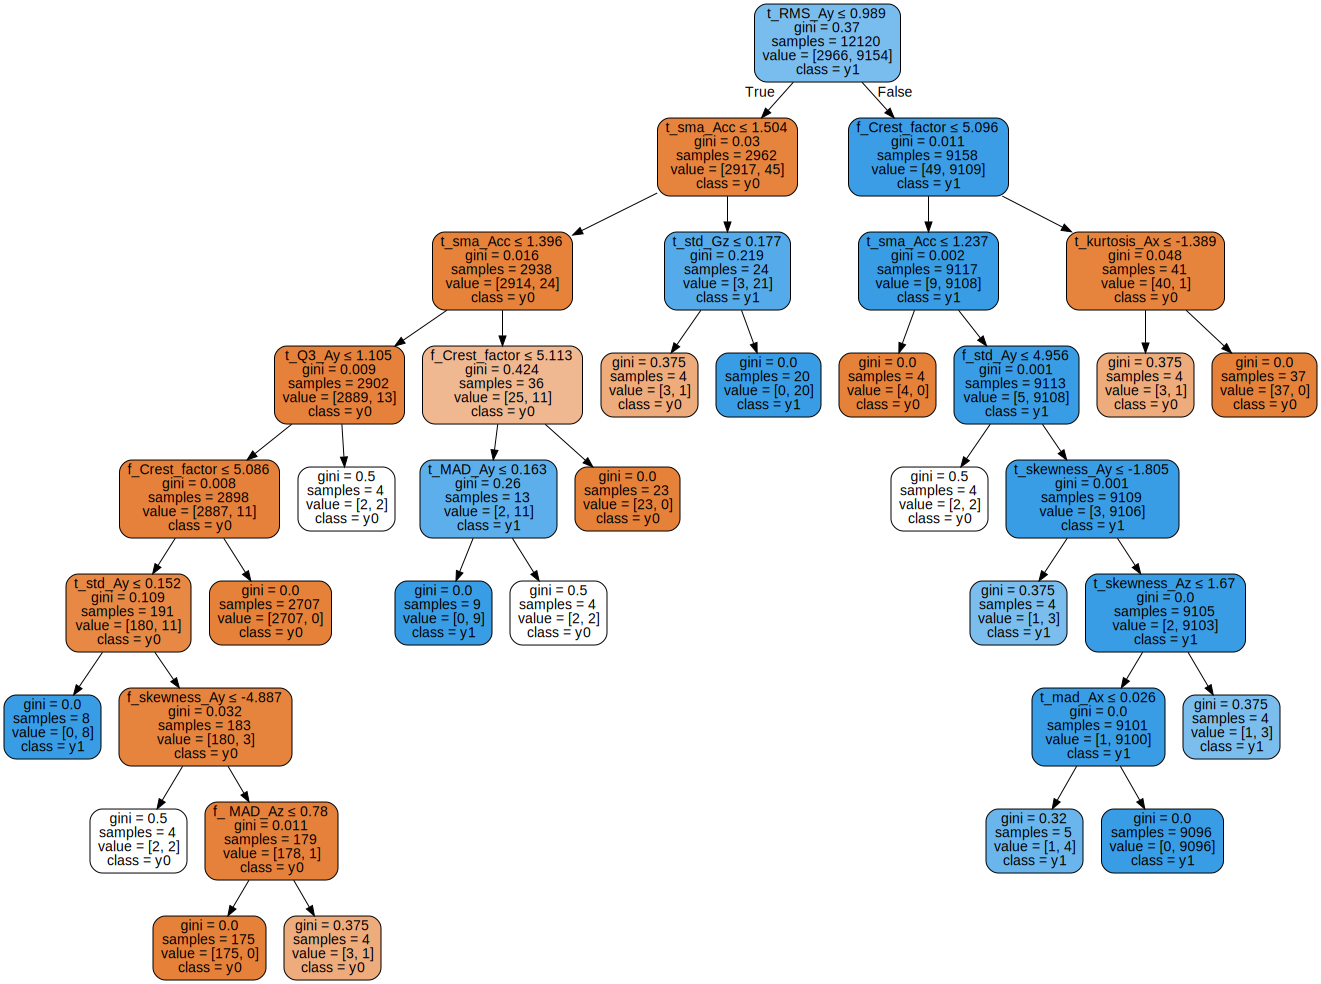

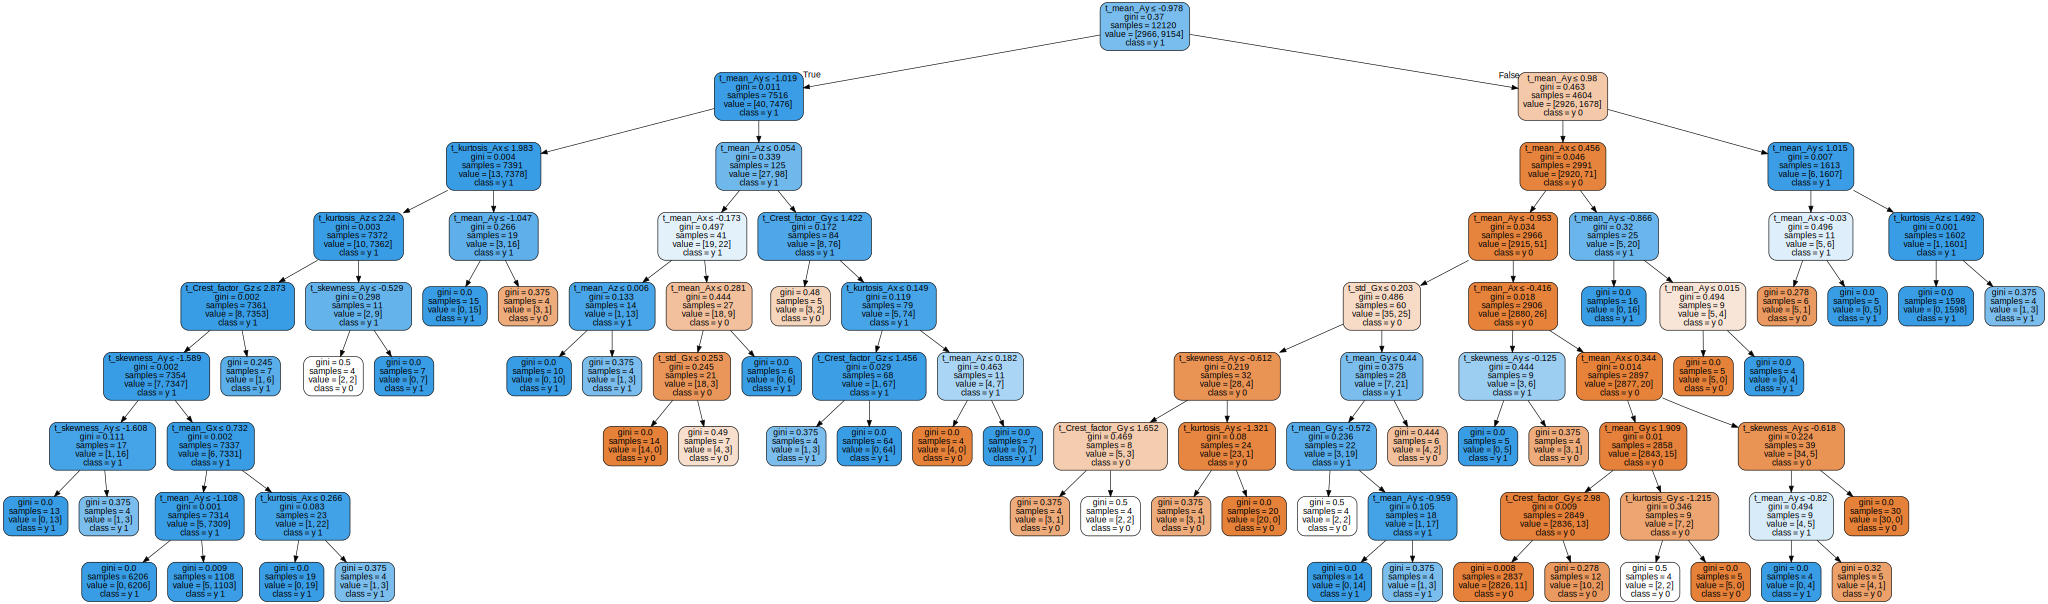

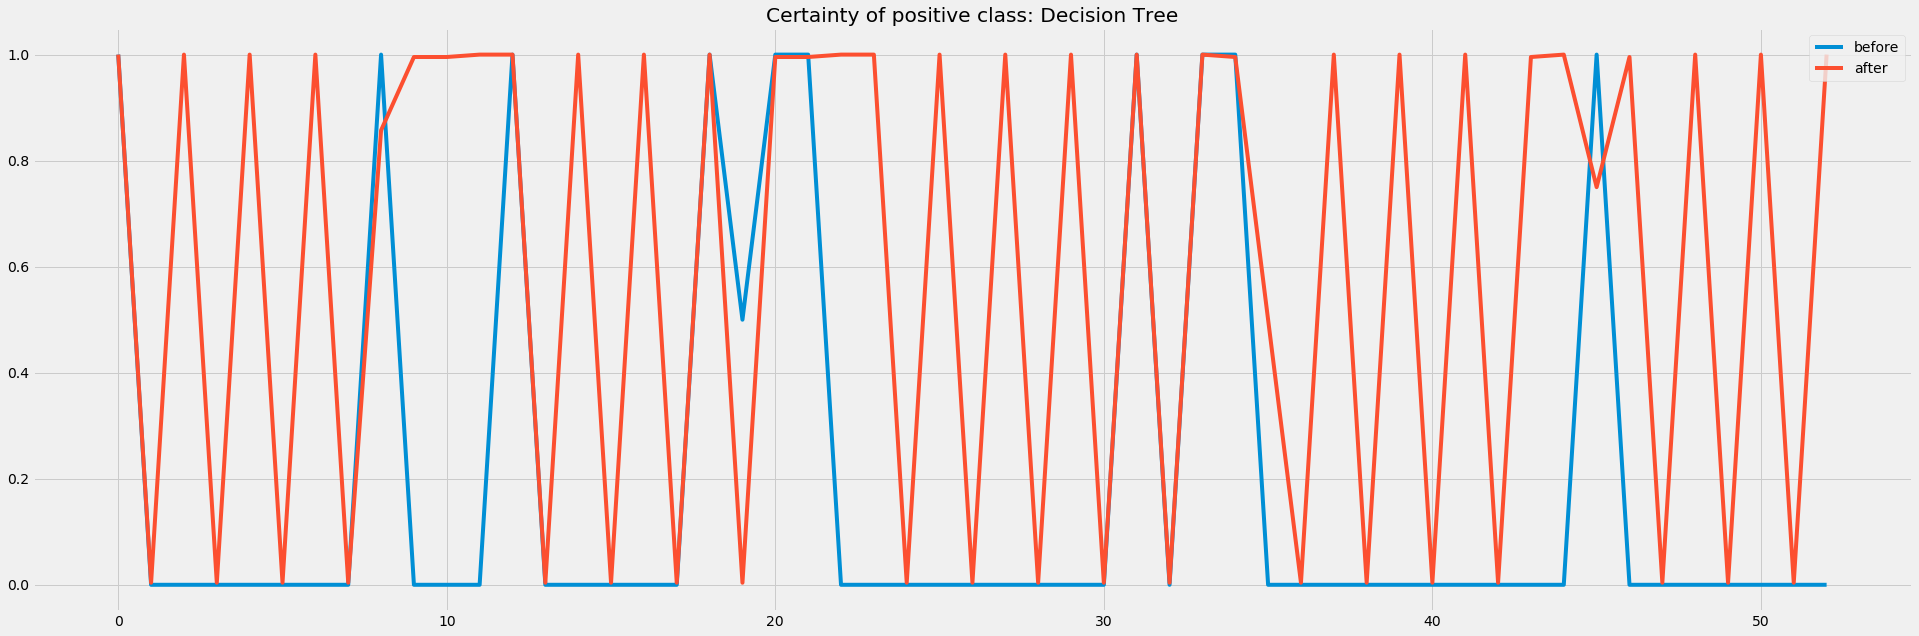

In [27]:
#Load dataset as pandas data frame
filename = 'LR_both_202.csv'
dataset = pd.read_csv(filename)

#Split data into input and output variable
X = dataset.iloc[:,0:dataset.shape[1]-1]
Y = dataset.iloc[:,-1]

X_trainB, X_testB, y_trainB, y_testB = train_test_split(X, Y,test_size=0.7,random_state = 100)
X_trainA, X_testA, y_trainA, y_testA = train_test_split(X, Y,test_size=0.7,random_state = 100)


# Removing Constant features
constant_filter = VarianceThreshold()
constant_filter.fit(X_trainA)
constant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[constant_filter.get_support()]]
X_trainA.drop(labels=constant_columns,axis=1, inplace=True) 
X_testA.drop(labels=constant_columns,axis=1, inplace=True)


RtestB = l202test.copy()
RtestA = l202test.copy()

RtestA.drop(labels=constant_columns,axis=1, inplace=True)

# Removing Quasi-Constant features
qconstant_filter = VarianceThreshold(0.01)
qconstant_filter.fit(X_trainA)
qconstant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[qconstant_filter.get_support()]]
X_trainA.drop(labels=qconstant_columns,axis=1, inplace=True) 
X_testA.drop(labels=qconstant_columns,axis=1, inplace=True)
RtestA.drop(labels=qconstant_columns,axis=1, inplace=True)

# Removing Correlated Features
correlated_features = set()  
correlation_matrix = X_trainA.corr(method = 'pearson')
for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.4:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
X_trainA.drop(labels=correlated_features,axis=1, inplace=True) 
X_testA.drop(labels=correlated_features,axis=1, inplace=True)
RtestA.drop(labels=correlated_features,axis=1, inplace=True)

# feature ranking and selection    
ranking_info, selected_features = feature_ranking_selection(X_trainA, y_trainA, 15)
X_trainA = X_trainA[selected_features]        
X_testA = X_testA[selected_features] 
RtestA = RtestA[selected_features]

#names = ["Nearest Neighbors","Decision Tree","Naive Bayes"]
names = ["Decision Tree"]

classifiers = [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
classifier2= [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
clf_bef = list()
clf_aft = list()

for name, clf, dlf in zip(names,classifiers,classifier2):
      
    
    # Before Feature Selection
    startB = time.time()
    clf.fit(X_trainB,y_trainB)
    #plot_decision_boundary(clf, X = X_train,Y = y_train)
    endB = time.time() 
    clf_bef.append(clf)
   # plot_decision_boundary(clf, X = X_train,Y = y_train)
    
    # after Feature Selection    
    startA = time.time()
    dlf.fit(X_trainA,y_trainA)
    endA = time.time()
    clf_aft.append(dlf)
    #plot_decision_boundary(dlf, X = X_train,Y = y_train)
    
    print('\t\t\t\tClassifier:',name.upper())
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')
         
    print('\t\tBefore Feature Selection\tAfter Feature Selection')
    print('No. of features:\t', X_trainB.shape[1],'\t\t\t',X_trainA.shape[1])
   
    class1B = clf.predict_proba(RtestB)[:,1]
    class1A = dlf.predict_proba(RtestA)[:,1]
    stepB = len(class1B[class1B >0.5])
    stepA = len(class1A[class1A >0.5])
    print('Step Detected:\t\t',stepB,'\t\t\t',stepA)
    print('27 is actual number of step in ID008440 ')
    
    
from sklearn.externals.six import StringIO
import pydotplus
from sklearn.tree import export_graphviz
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# plotting class probabilities
for name, clf, dlf in zip(names, clf_bef, clf_aft):
    # before feature selection
    
    columnsB=list(X_testB.columns)
    dot_data = StringIO()
    export_graphviz(clf,out_file=dot_data,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    graph.write_pdf(filename[:-4] +"_Before.pdf")
    # to display
    display(graphviz.Source(export_graphviz(clf,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)))
    
    # after feature selection
    columnsA=list(X_testA.columns)
    dot_dataA = StringIO()
    export_graphviz(dlf,out_file=dot_dataA,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_dataA.getvalue()) 
    graph.write_pdf(filename[:-4] +"_After.pdf")
    display(graphviz.Source(export_graphviz(dlf,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)))  
         
    class1B = clf.predict_proba(RtestB)[:,1]
    #print(class1B)
    class1A = dlf.predict_proba(RtestA)[:,1]
    #print(class1A)
    plt.figure(figsize=(30,10))
    plt.title('Certainty of positive class: '+ name)
    plt.plot(class1B,label = 'before')
    plt.plot(class1A,label = 'after')
    plt.legend(loc='upper right',ncol=1)
    plt.show()
   

# CLR606

				Classifier: DECISION TREE
---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
		Before Feature Selection	After Feature Selection
No. of features:	 606 			 15
Step Detected:		 44 			 49
27 is actual number of step in ID008440 


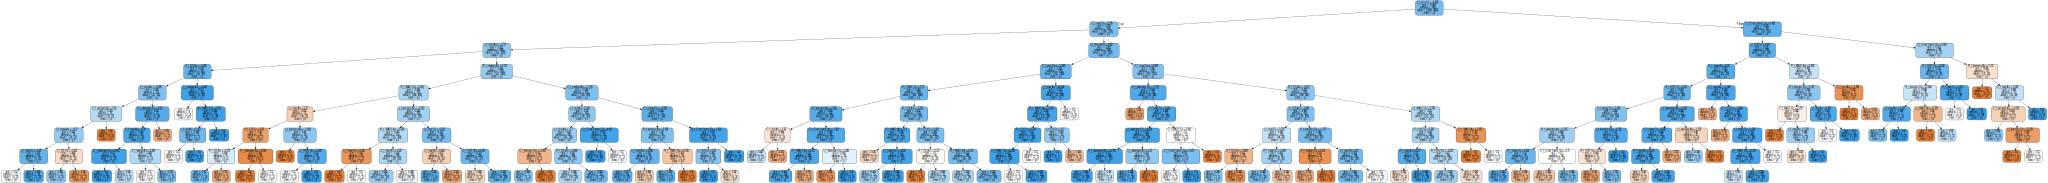

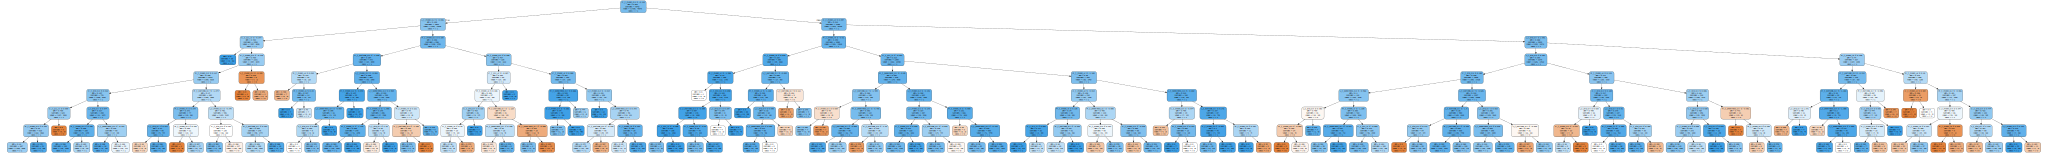

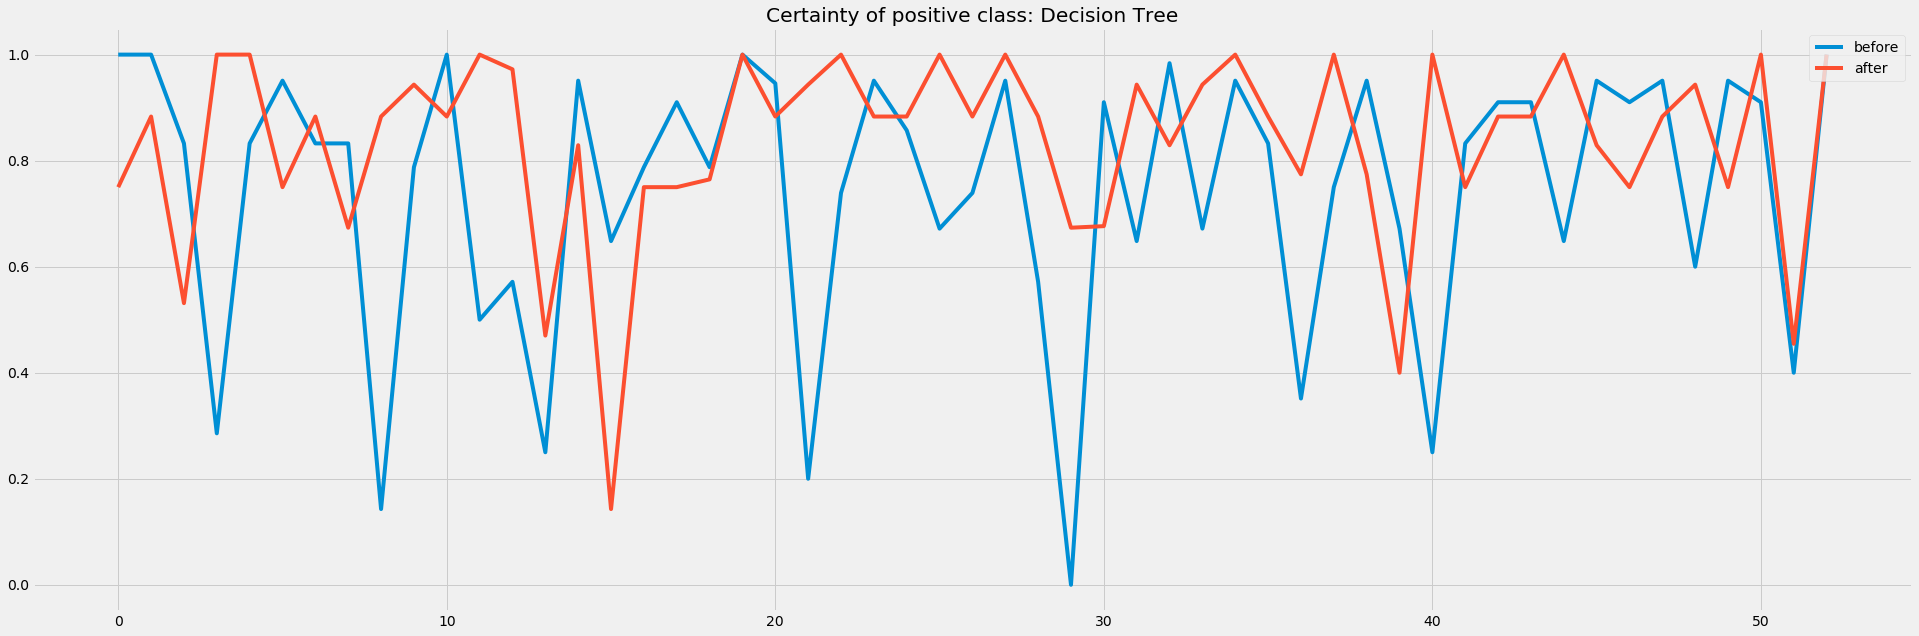

In [21]:
#Load dataset as pandas data frame
filename = 'CLR_both_606.csv'
dataset = pd.read_csv(filename)

#Split data into input and output variable
X = dataset.iloc[:,0:dataset.shape[1]-1]
Y = dataset.iloc[:,-1]

X_trainB, X_testB, y_trainB, y_testB = train_test_split(X, Y,test_size=0.7,random_state = 100)
X_trainA, X_testA, y_trainA, y_testA = train_test_split(X, Y,test_size=0.7,random_state = 100)


# Removing Constant features
constant_filter = VarianceThreshold()
constant_filter.fit(X_trainA)
constant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[constant_filter.get_support()]]
X_trainA.drop(labels=constant_columns,axis=1, inplace=True) 
X_testA.drop(labels=constant_columns,axis=1, inplace=True)


RtestB = CLR606Test.copy()
RtestA = CLR606Test.copy()

RtestA.drop(labels=constant_columns,axis=1, inplace=True)

# Removing Quasi-Constant features
qconstant_filter = VarianceThreshold(0.01)
qconstant_filter.fit(X_trainA)
qconstant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[qconstant_filter.get_support()]]
X_trainA.drop(labels=qconstant_columns,axis=1, inplace=True) 
X_testA.drop(labels=qconstant_columns,axis=1, inplace=True)
RtestA.drop(labels=qconstant_columns,axis=1, inplace=True)

# Removing Correlated Features
correlated_features = set()  
correlation_matrix = X_trainA.corr(method = 'pearson')
for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.4:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
X_trainA.drop(labels=correlated_features,axis=1, inplace=True) 
X_testA.drop(labels=correlated_features,axis=1, inplace=True)
RtestA.drop(labels=correlated_features,axis=1, inplace=True)

# feature ranking and selection    
ranking_info, selected_features = feature_ranking_selection(X_trainA, y_trainA, 15)
X_trainA = X_trainA[selected_features]        
X_testA = X_testA[selected_features] 
RtestA = RtestA[selected_features]

#names = ["Nearest Neighbors","Decision Tree","Naive Bayes"]
names = ["Decision Tree"]

classifiers = [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
classifier2= [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
clf_bef = list()
clf_aft = list()

for name, clf, dlf in zip(names,classifiers,classifier2):
      
    
    # Before Feature Selection
    startB = time.time()
    clf.fit(X_trainB,y_trainB)
    #plot_decision_boundary(clf, X = X_train,Y = y_train)
    endB = time.time() 
    clf_bef.append(clf)
   # plot_decision_boundary(clf, X = X_train,Y = y_train)
    
    # after Feature Selection    
    startA = time.time()
    dlf.fit(X_trainA,y_trainA)
    endA = time.time()
    clf_aft.append(dlf)
    #plot_decision_boundary(dlf, X = X_train,Y = y_train)
    
    print('\t\t\t\tClassifier:',name.upper())
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')
         
    print('\t\tBefore Feature Selection\tAfter Feature Selection')
    print('No. of features:\t', X_trainB.shape[1],'\t\t\t',X_trainA.shape[1])
   
    class1B = clf.predict_proba(RtestB)[:,1]
    class1A = dlf.predict_proba(RtestA)[:,1]
    stepB = len(class1B[class1B >0.5])
    stepA = len(class1A[class1A >0.5])
    print('Step Detected:\t\t',stepB,'\t\t\t',stepA)
    print('27 is actual number of step in ID008440 ')
    
    
from sklearn.externals.six import StringIO
import pydotplus
from sklearn.tree import export_graphviz
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# plotting class probabilities
for name, clf, dlf in zip(names, clf_bef, clf_aft):
    # before feature selection
    
    columnsB=list(X_testB.columns)
    dot_data = StringIO()
    export_graphviz(clf,out_file=dot_data,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    graph.write_pdf(filename[:-4] +"_Before.pdf")
    # to display
    display(graphviz.Source(export_graphviz(clf,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)))
    
    # after feature selection
    columnsA=list(X_testA.columns)
    dot_dataA = StringIO()
    export_graphviz(dlf,out_file=dot_dataA,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_dataA.getvalue()) 
    graph.write_pdf(filename[:-4] +"_After.pdf")
    display(graphviz.Source(export_graphviz(dlf,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)))  
         
    class1B = clf.predict_proba(RtestB)[:,1]
    #print(class1B)
    class1A = dlf.predict_proba(RtestA)[:,1]
    #print(class1A)
    plt.figure(figsize=(30,10))
    plt.title('Certainty of positive class: '+ name)
    plt.plot(class1B,label = 'before')
    plt.plot(class1A,label = 'after')
    plt.legend(loc='upper right',ncol=1)
    plt.show()
   

# CL404

In [ ]:
#Load dataset as pandas data frame
filename = 'CL_both_404.csv'
dataset = pd.read_csv(filename)

#Split data into input and output variable
X = dataset.iloc[:,0:dataset.shape[1]-1]
Y = dataset.iloc[:,-1]

X_trainB, X_testB, y_trainB, y_testB = train_test_split(X, Y,test_size=0.7,random_state = 100)
X_trainA, X_testA, y_trainA, y_testA = train_test_split(X, Y,test_size=0.7,random_state = 100)


# Removing Constant features
constant_filter = VarianceThreshold()
constant_filter.fit(X_trainA)
constant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[constant_filter.get_support()]]
X_trainA.drop(labels=constant_columns,axis=1, inplace=True) 
X_testA.drop(labels=constant_columns,axis=1, inplace=True)


RtestB = CL404Test.copy()
RtestA = CL404Test.copy()

RtestA.drop(labels=constant_columns,axis=1, inplace=True)

# Removing Quasi-Constant features
qconstant_filter = VarianceThreshold(0.01)
qconstant_filter.fit(X_trainA)
qconstant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[qconstant_filter.get_support()]]
X_trainA.drop(labels=qconstant_columns,axis=1, inplace=True) 
X_testA.drop(labels=qconstant_columns,axis=1, inplace=True)
RtestA.drop(labels=qconstant_columns,axis=1, inplace=True)

# Removing Correlated Features
correlated_features = set()  
correlation_matrix = X_trainA.corr(method = 'pearson')
for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.4:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
X_trainA.drop(labels=correlated_features,axis=1, inplace=True) 
X_testA.drop(labels=correlated_features,axis=1, inplace=True)
RtestA.drop(labels=correlated_features,axis=1, inplace=True)

# feature ranking and selection    
ranking_info, selected_features = feature_ranking_selection(X_trainA, y_trainA, 15)
X_trainA = X_trainA[selected_features]        
X_testA = X_testA[selected_features] 
RtestA = RtestA[selected_features]

#names = ["Nearest Neighbors","Decision Tree","Naive Bayes"]
names = ["Decision Tree"]

classifiers = [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
classifier2= [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
clf_bef = list()
clf_aft = list()

for name, clf, dlf in zip(names,classifiers,classifier2):
      
    
    # Before Feature Selection
    startB = time.time()
    clf.fit(X_trainB,y_trainB)
    #plot_decision_boundary(clf, X = X_train,Y = y_train)
    endB = time.time() 
    clf_bef.append(clf)
   # plot_decision_boundary(clf, X = X_train,Y = y_train)
    
    # after Feature Selection    
    startA = time.time()
    dlf.fit(X_trainA,y_trainA)
    endA = time.time()
    clf_aft.append(dlf)
    #plot_decision_boundary(dlf, X = X_train,Y = y_train)
    
    print('\t\t\t\tClassifier:',name.upper())
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')
         
    print('\t\tBefore Feature Selection\tAfter Feature Selection')
    print('No. of features:\t', X_trainB.shape[1],'\t\t\t',X_trainA.shape[1])
   
    class1B = clf.predict_proba(RtestB)[:,1]
    class1A = dlf.predict_proba(RtestA)[:,1]
    stepB = len(class1B[class1B >0.5])
    stepA = len(class1A[class1A >0.5])
    print('Step Detected:\t\t',stepB,'\t\t\t',stepA)
    print('27 is actual number of step in ID008440 ')
    
    
from sklearn.externals.six import StringIO
import pydotplus
from sklearn.tree import export_graphviz
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

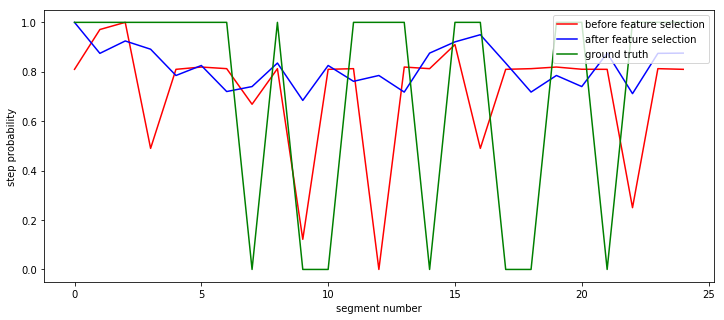

In [19]:
# plotting class probabilities
for name, clf, dlf in zip(names, clf_bef, clf_aft):
    # before feature selection
    
    columnsB=list(X_testB.columns)
    dot_data = StringIO()
    export_graphviz(clf,out_file=dot_data,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    graph.write_pdf(filename[:-4] +"_Before.pdf")
    # to display
    #display(graphviz.Source(export_graphviz(clf,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)))
    
    # after feature selection
    columnsA=list(X_testA.columns)
    dot_dataA = StringIO()
    export_graphviz(dlf,out_file=dot_dataA,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_dataA.getvalue()) 
    graph.write_pdf(filename[:-4] +"_After.pdf")
    #display(graphviz.Source(export_graphviz(dlf,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)))  
         
    class1B = clf.predict_proba(X_testB[15:40])[:,1]
    #print(class1B)
    class1A = dlf.predict_proba(X_testA[15:40])[:,1]
    #print(class1A)
    plt.figure(figsize=(12,5))
   # plt.title('Certainty of a step detecion')
    plt.plot(class1B,label = 'before feature selection', color ='red')
    plt.plot(class1A,label = 'after feature selection',color ='blue')
    plt.plot(y_testB[15:40].values,label = 'ground truth',color ='green')
    plt.xlabel('segment number')
    plt.ylabel('step probability')
    plt.legend(loc='upper right',ncol=1)
    plt.savefig('certainty2.pdf', dpi=1500)
    plt.show()
   

# CR404

				Classifier: DECISION TREE
---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
		Before Feature Selection	After Feature Selection
No. of features:	 404 			 15
Step Detected:		 42 			 50
27 is actual number of step in ID008440 


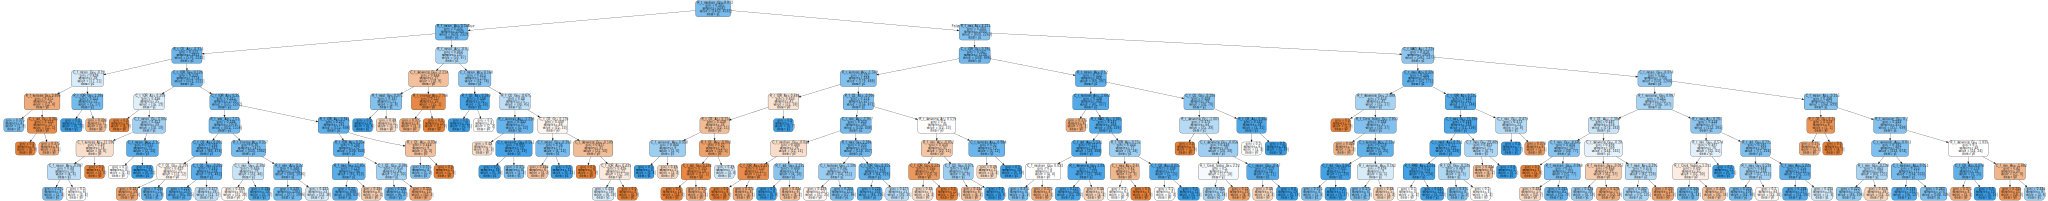

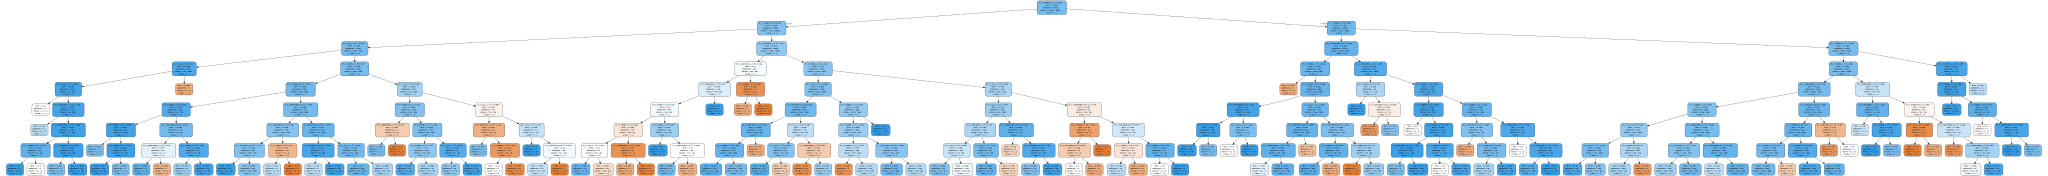

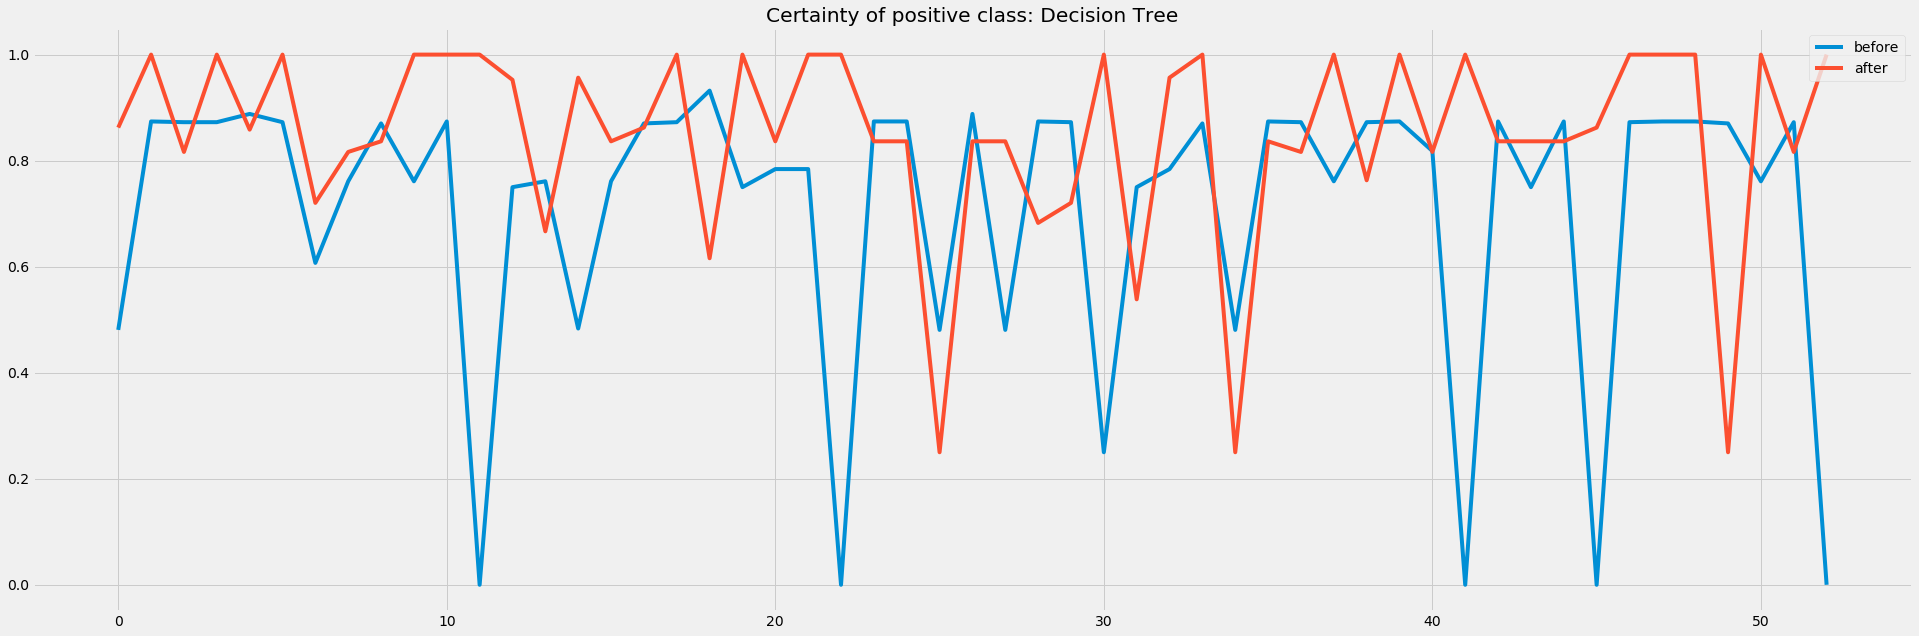

In [22]:
#Load dataset as pandas data frame
filename = 'CR_both_404.csv'
dataset = pd.read_csv(filename)

#Split data into input and output variable
X = dataset.iloc[:,0:dataset.shape[1]-1]
Y = dataset.iloc[:,-1]

X_trainB, X_testB, y_trainB, y_testB = train_test_split(X, Y,test_size=0.7,random_state = 100)
X_trainA, X_testA, y_trainA, y_testA = train_test_split(X, Y,test_size=0.7,random_state = 100)


# Removing Constant features
constant_filter = VarianceThreshold()
constant_filter.fit(X_trainA)
constant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[constant_filter.get_support()]]
X_trainA.drop(labels=constant_columns,axis=1, inplace=True) 
X_testA.drop(labels=constant_columns,axis=1, inplace=True)


RtestB = CR404Test.copy()
RtestA = CR404Test.copy()

RtestA.drop(labels=constant_columns,axis=1, inplace=True)

# Removing Quasi-Constant features
qconstant_filter = VarianceThreshold(0.01)
qconstant_filter.fit(X_trainA)
qconstant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[qconstant_filter.get_support()]]
X_trainA.drop(labels=qconstant_columns,axis=1, inplace=True) 
X_testA.drop(labels=qconstant_columns,axis=1, inplace=True)
RtestA.drop(labels=qconstant_columns,axis=1, inplace=True)

# Removing Correlated Features
correlated_features = set()  
correlation_matrix = X_trainA.corr(method = 'pearson')
for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.4:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
X_trainA.drop(labels=correlated_features,axis=1, inplace=True) 
X_testA.drop(labels=correlated_features,axis=1, inplace=True)
RtestA.drop(labels=correlated_features,axis=1, inplace=True)

# feature ranking and selection    
ranking_info, selected_features = feature_ranking_selection(X_trainA, y_trainA, 15)
X_trainA = X_trainA[selected_features]        
X_testA = X_testA[selected_features] 
RtestA = RtestA[selected_features]

#names = ["Nearest Neighbors","Decision Tree","Naive Bayes"]
names = ["Decision Tree"]

classifiers = [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
classifier2= [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
clf_bef = list()
clf_aft = list()

for name, clf, dlf in zip(names,classifiers,classifier2):
      
    
    # Before Feature Selection
    startB = time.time()
    clf.fit(X_trainB,y_trainB)
    #plot_decision_boundary(clf, X = X_train,Y = y_train)
    endB = time.time() 
    clf_bef.append(clf)
   # plot_decision_boundary(clf, X = X_train,Y = y_train)
    
    # after Feature Selection    
    startA = time.time()
    dlf.fit(X_trainA,y_trainA)
    endA = time.time()
    clf_aft.append(dlf)
    #plot_decision_boundary(dlf, X = X_train,Y = y_train)
    
    print('\t\t\t\tClassifier:',name.upper())
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')
         
    print('\t\tBefore Feature Selection\tAfter Feature Selection')
    print('No. of features:\t', X_trainB.shape[1],'\t\t\t',X_trainA.shape[1])
   
    class1B = clf.predict_proba(RtestB)[:,1]
    class1A = dlf.predict_proba(RtestA)[:,1]
    stepB = len(class1B[class1B >0.5])
    stepA = len(class1A[class1A >0.5])
    print('Step Detected:\t\t',stepB,'\t\t\t',stepA)
    print('27 is actual number of step in ID008440 ')
    
    
from sklearn.externals.six import StringIO
import pydotplus
from sklearn.tree import export_graphviz
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# plotting class probabilities
for name, clf, dlf in zip(names, clf_bef, clf_aft):
    # before feature selection
    
    columnsB=list(X_testB.columns)
    dot_data = StringIO()
    export_graphviz(clf,out_file=dot_data,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    graph.write_pdf(filename[:-4] +"_Before.pdf")
    # to display
    display(graphviz.Source(export_graphviz(clf,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)))
    
    # after feature selection
    columnsA=list(X_testA.columns)
    dot_dataA = StringIO()
    export_graphviz(dlf,out_file=dot_dataA,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_dataA.getvalue()) 
    graph.write_pdf(filename[:-4] +"_After.pdf")
    display(graphviz.Source(export_graphviz(dlf,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)))  
         
    class1B = clf.predict_proba(RtestB)[:,1]
    #print(class1B)
    class1A = dlf.predict_proba(RtestA)[:,1]
    #print(class1A)
    plt.figure(figsize=(30,10))
    plt.title('Certainty of positive class: '+ name)
    plt.plot(class1B,label = 'before')
    plt.plot(class1A,label = 'after')
    plt.legend(loc='upper right',ncol=1)
    plt.show()
   

# LR404

				Classifier: DECISION TREE
---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
		Before Feature Selection	After Feature Selection
No. of features:	 404 			 15
Step Detected:		 47 			 45
27 is actual number of step in ID008440 


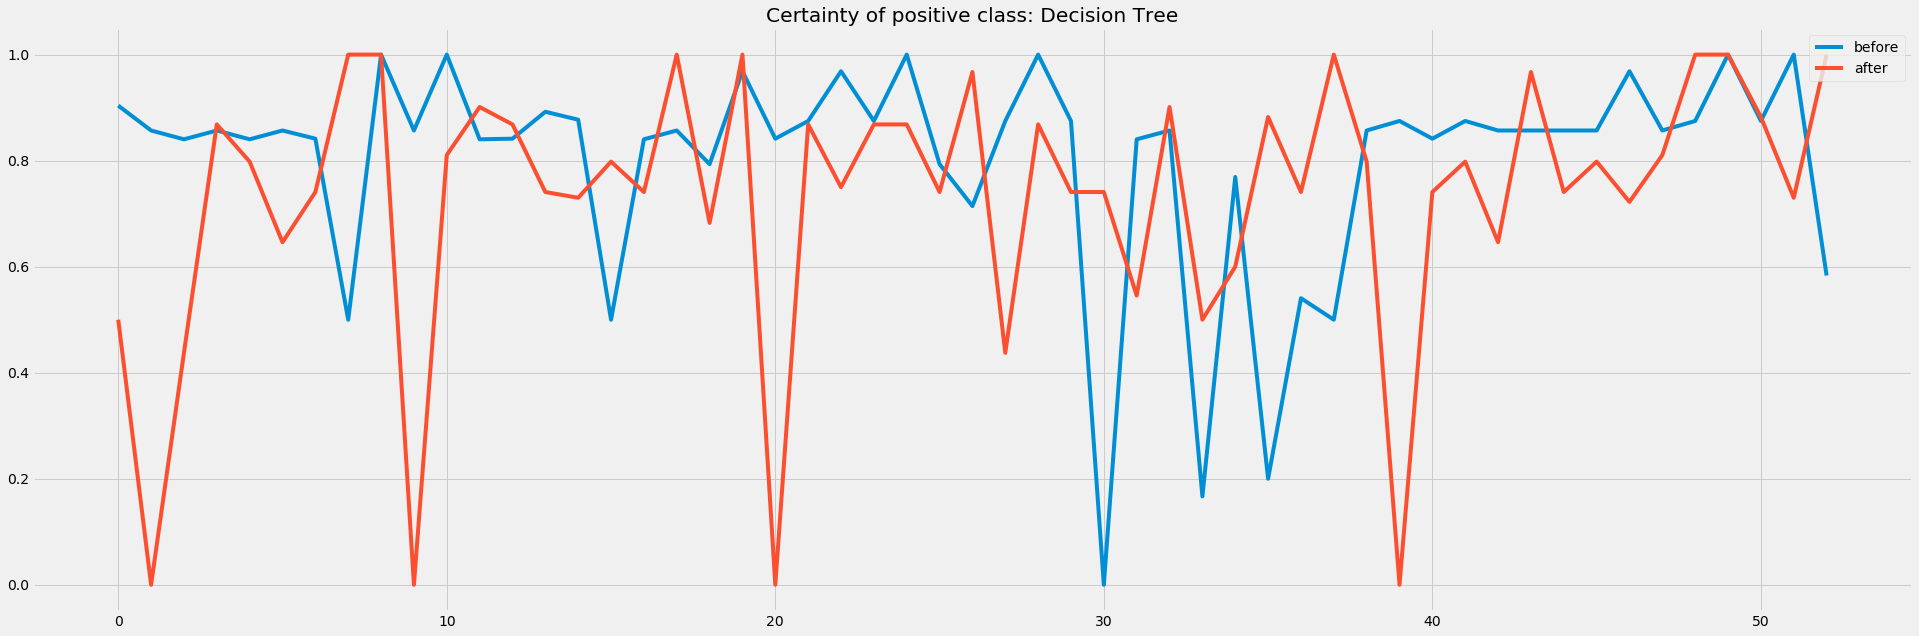

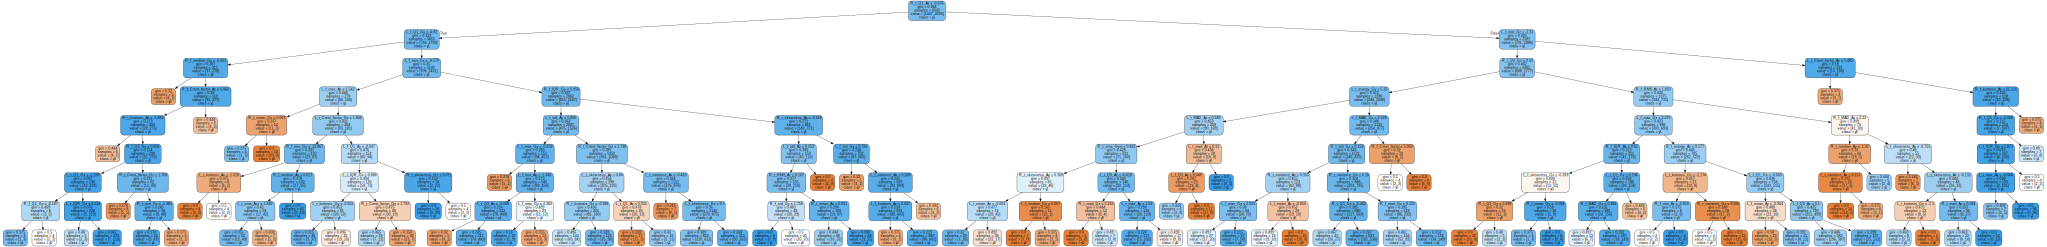

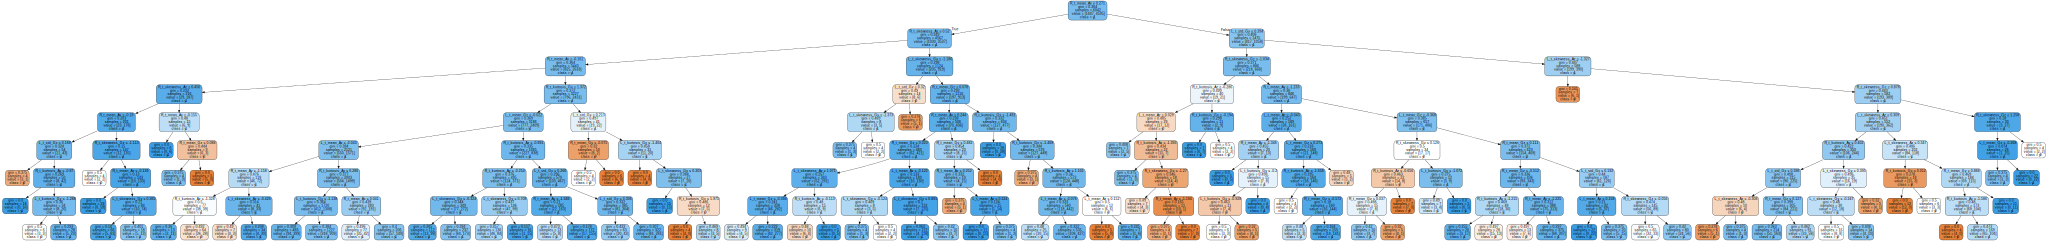

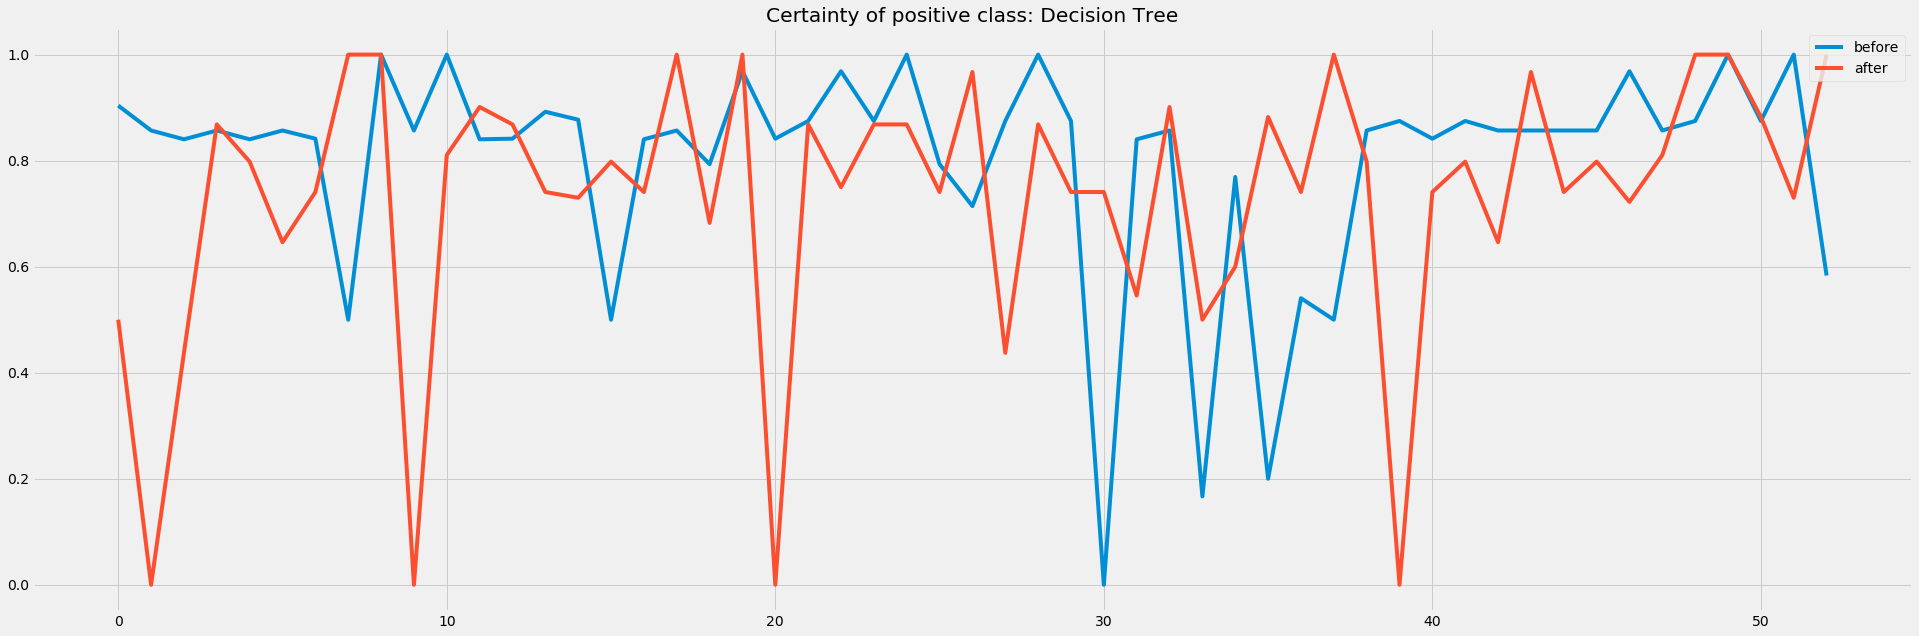

In [29]:
#Load dataset as pandas data frame
filename = 'LR_both_404.csv'
dataset = pd.read_csv(filename)

#Split data into input and output variable
X = dataset.iloc[:,0:dataset.shape[1]-1]
Y = dataset.iloc[:,-1]

X_trainB, X_testB, y_trainB, y_testB = train_test_split(X, Y,test_size=0.7,random_state = 100)
X_trainA, X_testA, y_trainA, y_testA = train_test_split(X, Y,test_size=0.7,random_state = 100)


# Removing Constant features
constant_filter = VarianceThreshold()
constant_filter.fit(X_trainA)
constant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[constant_filter.get_support()]]
X_trainA.drop(labels=constant_columns,axis=1, inplace=True) 
X_testA.drop(labels=constant_columns,axis=1, inplace=True)


RtestB = LR404Test.copy()
RtestA = LR404Test.copy()

RtestA.drop(labels=constant_columns,axis=1, inplace=True)

# Removing Quasi-Constant features
qconstant_filter = VarianceThreshold(0.01)
qconstant_filter.fit(X_trainA)
qconstant_columns = [col for col in X_trainA.columns
                    if col not in X_trainA.columns[qconstant_filter.get_support()]]
X_trainA.drop(labels=qconstant_columns,axis=1, inplace=True) 
X_testA.drop(labels=qconstant_columns,axis=1, inplace=True)
RtestA.drop(labels=qconstant_columns,axis=1, inplace=True)

# Removing Correlated Features
correlated_features = set()  
correlation_matrix = X_trainA.corr(method = 'pearson')
for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.4:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
X_trainA.drop(labels=correlated_features,axis=1, inplace=True) 
X_testA.drop(labels=correlated_features,axis=1, inplace=True)
RtestA.drop(labels=correlated_features,axis=1, inplace=True)

# feature ranking and selection    
ranking_info, selected_features = feature_ranking_selection(X_trainA, y_trainA, 15)
X_trainA = X_trainA[selected_features]        
X_testA = X_testA[selected_features] 
RtestA = RtestA[selected_features]

#names = ["Nearest Neighbors","Decision Tree","Naive Bayes"]
names = ["Decision Tree"]

classifiers = [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
classifier2= [
    #KNeighborsClassifier(5, n_jobs= -1 ),
    DecisionTreeClassifier(max_depth = 8,min_samples_leaf=4,random_state = 100),
    #GaussianNB(),
   ]
clf_bef = list()
clf_aft = list()

for name, clf, dlf in zip(names,classifiers,classifier2):
      
    
    # Before Feature Selection
    startB = time.time()
    clf.fit(X_trainB,y_trainB)
    #plot_decision_boundary(clf, X = X_train,Y = y_train)
    endB = time.time() 
    clf_bef.append(clf)
   # plot_decision_boundary(clf, X = X_train,Y = y_train)
    
    # after Feature Selection    
    startA = time.time()
    dlf.fit(X_trainA,y_trainA)
    endA = time.time()
    clf_aft.append(dlf)
    #plot_decision_boundary(dlf, X = X_train,Y = y_train)
    
    print('\t\t\t\tClassifier:',name.upper())
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')
         
    print('\t\tBefore Feature Selection\tAfter Feature Selection')
    print('No. of features:\t', X_trainB.shape[1],'\t\t\t',X_trainA.shape[1])
   
    class1B = clf.predict_proba(RtestB)[:,1]
    class1A = dlf.predict_proba(RtestA)[:,1]
    stepB = len(class1B[class1B >0.5])
    stepA = len(class1A[class1A >0.5])
    print('Step Detected:\t\t',stepB,'\t\t\t',stepA)
    print('27 is actual number of step in ID008440 ')
    
    
# plotting class probabilities
for name, clf, dlf in zip(names, clf_bef, clf_aft):  
    class1B = clf.predict_proba(RtestB)[:,1]
    #print(class1B)
    class1A = dlf.predict_proba(RtestA)[:,1]
#print(class1A)
    plt.figure(figsize=(30,10))
    plt.title('Certainty of positive class: '+ name)
    plt.plot(class1B,label = 'before')
    plt.plot(class1A,label = 'after')
    plt.legend(loc='upper right',ncol=1)
    plt.show()
from sklearn.externals.six import StringIO
import pydotplus
from sklearn.tree import export_graphviz
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# plotting class probabilities
for name, clf, dlf in zip(names, clf_bef, clf_aft):
    # before feature selection
    
    columnsB=list(X_testB.columns)
    dot_data = StringIO()
    export_graphviz(clf,out_file=dot_data,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    graph.write_pdf(filename[:-4] +"_Before.pdf")
    # to display
    display(graphviz.Source(export_graphviz(clf,filled=True,rounded=True,special_characters=True,feature_names=columnsB,class_names=True)))
    
    # after feature selection
    columnsA=list(X_testA.columns)
    dot_dataA = StringIO()
    export_graphviz(dlf,out_file=dot_dataA,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)
    graph = pydotplus.graph_from_dot_data(dot_dataA.getvalue()) 
    graph.write_pdf(filename[:-4] +"_After.pdf")
    display(graphviz.Source(export_graphviz(dlf,filled=True,rounded=True,special_characters=True,feature_names=columnsA,class_names=True)))  
         
    class1B = clf.predict_proba(RtestB)[:,1]
    #print(class1B)
    class1A = dlf.predict_proba(RtestA)[:,1]
    #print(class1A)
    plt.figure(figsize=(30,10))
    plt.title('Certainty of positive class: '+ name)
    plt.plot(class1B,label = 'before')
    plt.plot(class1A,label = 'after')
    plt.legend(loc='upper right',ncol=1)
    plt.show()